## Aquisição dos Dados

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para tratamento de dados
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

#Bibliotecas para processamento
from sklearn.preprocessing import RobustScaler, StandardScaler

#Bibliotecas para dimensionalidade
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#Bibliotecas para clusterizaçao
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.vq import whiten
from sklearn.cluster import KMeans, estimate_bandwidth, MeanShift, DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator

from tqdm import tqdm

#Bibliotecas para regressão
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,\
                            accuracy_score, confusion_matrix, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Carregando arquivo de dados climáticos:**

In [ ]:
clima = pd.read_csv (r'/content/drive/My Drive/Colab Notebooks/Clima_2012_2021.CSV', decimal=",", sep=";") 

Na tabela existem alguns valores -9999 que são erros de leitura da estação meteorológica que vamos ter que excluir. Aqui transformei estes valores em None/NaN (Not a Number)

In [ ]:
clima.replace({-9999.0: None}, inplace=True)

Ajusta nomes das colunas, e também ajusta o formato da coluna de data, convertendo de string para date. Também ordena a tabela pela data.


In [ ]:
clima.columns=['DATA','HORA','PRECIPITACAO','PRESSAO ATMOSFERICA','RADIACAO GLOBAL','TEMPERATURA','PONTO DE ORVALHO','UMIDADE RELATIVA DO AR','VELOCIDADE DO VENTO']
clima["DATA"] = pd.to_datetime(clima["DATA"],format="%d/%m/%Y").dt.date
clima = clima.sort_values(by="DATA")

In [ ]:
clima

,DATA,HORA,PRECIPITACAO,PRESSAO ATMOSFERICA,RADIACAO GLOBAL,TEMPERATURA,PONTO DE ORVALHO,UMIDADE RELATIVA DO AR,VELOCIDADE DO VENTO
0,2012-01-01,00:00,0.0,875.2,None,18.9,17.2,90.0,1.9
23,2012-01-01,23:00,0.0,873.5,None,18.4,16.2,87.0,1.3
22,2012-01-01,22:00,0.0,873.0,91.9,19.5,16.5,83.0,0.9
21,2012-01-01,21:00,0.0,872.5,486.7,21.8,16.7,73.0,2.4
20,2012-01-01,20:00,0.0,872.2,1591.8,23.4,16.5,65.0,2.6
...,...,...,...,...,...,...,...,...,...
87649,2021-12-31,0100 UTC,4.8,874.9,0.0,18.6,17.3,92.0,1.7
87648,2021-12-31,0000 UTC,2.8,874.4,0.0,18.2,17.1,93.0,1.1
87670,2021-12-31,2200 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87658,2021-12-31,1000 UTC,2.2,873.4,69.0,17.8,16.8,94.0,0.0


Agrupa o valor de cada variável por dia, por exemplo, temperatura média do DIA 01/02/2015. Isso porque os valores estão por hora, precisamos deles por dia para fazer as análises já que os focos de incêndios são diários.

Também ajusta as colunas e indices da nova tabela.

In [ ]:
agrupados=clima.groupby('DATA').agg({
    'PRECIPITACAO':['sum','mean'],
    'PRESSAO ATMOSFERICA':'mean',
    'RADIACAO GLOBAL':'mean',
    'TEMPERATURA':['min','max','mean'],
    'PONTO DE ORVALHO':'mean',
    'UMIDADE RELATIVA DO AR':['min','mean'],
    'VELOCIDADE DO VENTO':'mean'
})

agrupados.columns=['PRECIPITACAO TOTAL','PRECIPITACAO MEDIA','PRESSAO ATMOSFERICA MEDIA','RADIACAO GLOBAL MEDIA','TEMPERATURA MINIMA',
'TEMPERATURA MAXIMA','TEMPERATURA MEDIA','PONTO DE ORVALHO MEDIA','UMIDADE RELATIVA DO AR MINIMA','UMIDADE RELATIVA DO AR MEDIA','VELOCIDADE DO VENTO MEDIA']
agrupados=agrupados.reset_index()

In [ ]:
agrupados

,DATA,PRECIPITACAO TOTAL,PRECIPITACAO MEDIA,PRESSAO ATMOSFERICA MEDIA,RADIACAO GLOBAL MEDIA,TEMPERATURA MINIMA,TEMPERATURA MAXIMA,TEMPERATURA MEDIA,PONTO DE ORVALHO MEDIA,UMIDADE RELATIVA DO AR MINIMA,UMIDADE RELATIVA DO AR MEDIA,VELOCIDADE DO VENTO MEDIA
0,2012-01-01,5.8,0.241667,874.591667,1172.614286,18.4,23.8,20.212500,17.058333,61.0,82.833333,2.175000
1,2012-01-02,18.2,0.758333,872.995833,374.823077,18.1,19.8,19.116667,16.941667,81.0,87.333333,4.295833
2,2012-01-03,49.6,2.066667,874.816667,464.835714,16.7,21.1,18.091667,16.895833,78.0,92.875000,3.137500
3,2012-01-04,47.4,1.975000,876.541667,682.078571,15.6,20.1,17.270833,16.037500,80.0,92.583333,1.666667
4,2012-01-05,6.0,0.250000,875.770833,1455.192308,17.2,25.0,20.275000,15.920833,59.0,76.666667,1.625000
...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2021-12-27,35.4,1.475000,874.258333,373.850000,17.5,21.6,18.937500,17.708333,82.0,92.750000,1.041667
3649,2021-12-28,14.6,0.608333,876.045833,352.725000,18.2,20.5,19.083333,17.079167,81.0,88.250000,2.125000
3650,2021-12-29,0.2,0.008333,876.650000,699.587500,17.8,25.4,20.337500,17.262500,61.0,83.083333,1.266667
3651,2021-12-30,4.8,0.200000,874.437500,419.695833,18.1,23.1,19.987500,17.162500,71.0,84.125000,1.391667


**Carregando arquivo de Focos de incêndio:**

Carrega arquivo de focos de incêndios: cada entrada é um foco de incêndio, contendo a data e hora, e outros dados irrelevantes para nossas análises.

In [ ]:
focos = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Focos_2012_2021.CSV', decimal=",", sep=";")

Também realiza o ajuste no formato da coluna de data, convertendo de string para date. Também ordena a tabela pela data.

In [ ]:
focos["datahora"] = pd.to_datetime(focos["datahora"]).dt.date
focos=focos.groupby("datahora").size().sort_values().reset_index("datahora")
focos.columns = ["DATA","QUANTIDADE FOCOS"]

In [ ]:
focos

,DATA,QUANTIDADE FOCOS
0,2016-12-10,1
1,2019-06-20,1
2,2019-06-23,1
3,2013-10-10,1
4,2016-08-19,1
...,...,...
934,2021-09-16,284
935,2017-08-09,340
936,2019-09-26,448
937,2017-09-09,584


**Juntando os Datasets:**

Junta as duas tabelas em uma única (clima + focos), utilizando a data como chave e concatenando a coluna de quantidade de focos no final

In [ ]:
merjado = pd.merge(agrupados, focos, on="DATA", how="left")

Troca os valores NaN de "quantidade focos" por 0, e cria uma coluna extra ('ocorreu fogo'), indicando se houve (True) ou não (False) algum foco de incêndio naquela data, e salva como um novo csv.

In [ ]:
merjado["QUANTIDADE FOCOS"] = merjado["QUANTIDADE FOCOS"].fillna(0)
merjado["OCORREU FOGO"] = np.where(merjado['QUANTIDADE FOCOS'] > 0, True, False)

In [ ]:
merjado

,DATA,PRECIPITACAO TOTAL,PRECIPITACAO MEDIA,PRESSAO ATMOSFERICA MEDIA,RADIACAO GLOBAL MEDIA,TEMPERATURA MINIMA,TEMPERATURA MAXIMA,TEMPERATURA MEDIA,PONTO DE ORVALHO MEDIA,UMIDADE RELATIVA DO AR MINIMA,UMIDADE RELATIVA DO AR MEDIA,VELOCIDADE DO VENTO MEDIA,QUANTIDADE FOCOS,OCORREU FOGO
0,2012-01-01,5.8,0.241667,874.591667,1172.614286,18.4,23.8,20.212500,17.058333,61.0,82.833333,2.175000,0.0,False
1,2012-01-02,18.2,0.758333,872.995833,374.823077,18.1,19.8,19.116667,16.941667,81.0,87.333333,4.295833,0.0,False
2,2012-01-03,49.6,2.066667,874.816667,464.835714,16.7,21.1,18.091667,16.895833,78.0,92.875000,3.137500,0.0,False
3,2012-01-04,47.4,1.975000,876.541667,682.078571,15.6,20.1,17.270833,16.037500,80.0,92.583333,1.666667,0.0,False
4,2012-01-05,6.0,0.250000,875.770833,1455.192308,17.2,25.0,20.275000,15.920833,59.0,76.666667,1.625000,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2021-12-27,35.4,1.475000,874.258333,373.850000,17.5,21.6,18.937500,17.708333,82.0,92.750000,1.041667,0.0,False
3649,2021-12-28,14.6,0.608333,876.045833,352.725000,18.2,20.5,19.083333,17.079167,81.0,88.250000,2.125000,0.0,False
3650,2021-12-29,0.2,0.008333,876.650000,699.587500,17.8,25.4,20.337500,17.262500,61.0,83.083333,1.266667,0.0,False
3651,2021-12-30,4.8,0.200000,874.437500,419.695833,18.1,23.1,19.987500,17.162500,71.0,84.125000,1.391667,0.0,False


## Pre-processamento dos Dados

In [ ]:
#Função para identificar dados faltantes:

def find_missing(data):
    '''
    Função para identificar e listar as variáveis com valores faltantes
    '''
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissing':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isna().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        miss_df = miss_df.append(dict(zip(miss_df.columns,[col,sum_miss_val,percent_miss_val])), ignore_index=True)
        miss_df = miss_df[miss_df['TotalMissing']>0].sort_values('TotalMissing', ascending=False)
    return miss_df

In [ ]:
find_missing(merjado)

,ColumnName,TotalMissing,PercentMissing
0,PRECIPITACAO MEDIA,265.0,7.25
1,PONTO DE ORVALHO MEDIA,31.0,0.85
2,UMIDADE RELATIVA DO AR MINIMA,30.0,0.82
3,UMIDADE RELATIVA DO AR MEDIA,30.0,0.82
4,RADIACAO GLOBAL MEDIA,19.0,0.52
5,PRESSAO ATMOSFERICA MEDIA,18.0,0.49
6,TEMPERATURA MINIMA,18.0,0.49
7,TEMPERATURA MAXIMA,18.0,0.49
8,TEMPERATURA MEDIA,18.0,0.49
9,VELOCIDADE DO VENTO MEDIA,18.0,0.49


Substituiremos os dados faltantes de cada variável por sua mediana.

In [ ]:
merjado.describe(percentiles = [.1, .25, .5, .75, .95, .99]).round(2)

,PRECIPITACAO TOTAL,PRECIPITACAO MEDIA,PRESSAO ATMOSFERICA MEDIA,RADIACAO GLOBAL MEDIA,TEMPERATURA MINIMA,TEMPERATURA MAXIMA,TEMPERATURA MEDIA,PONTO DE ORVALHO MEDIA,UMIDADE RELATIVA DO AR MINIMA,UMIDADE RELATIVA DO AR MEDIA,VELOCIDADE DO VENTO MEDIA,QUANTIDADE FOCOS
count,3653.00,3388.00,3635.00,3634.00,3635.00,3635.00,3635.00,3622.00,3623.00,3623.00,3635.00,3653.00
mean,3.19,0.14,877.18,1259.46,16.54,26.04,20.68,11.85,37.58,58.26,2.06,4.70
std,8.65,0.37,1.94,501.05,2.16,2.52,1.94,4.66,19.97,19.06,0.86,25.14
min,0.00,0.00,870.00,111.59,8.30,17.50,14.44,-9.73,7.00,8.00,0.43,0.00
10%,0.00,0.00,874.92,627.12,13.50,22.90,18.31,5.19,11.00,32.33,1.12,0.00
25%,0.00,0.00,875.82,839.78,15.30,24.40,19.44,8.43,20.00,43.11,1.46,0.00
50%,0.00,0.00,877.00,1222.13,17.00,26.00,20.52,12.68,37.00,58.33,1.90,0.00
75%,1.00,0.06,878.51,1659.75,17.90,27.60,21.79,15.81,54.00,74.38,2.50,1.00
95%,20.40,0.89,880.45,2062.84,19.30,30.40,24.28,17.71,70.00,87.04,3.70,20.00
99%,42.20,1.82,881.83,2224.10,21.17,32.10,25.83,18.33,81.00,91.60,4.82,95.96


In [ ]:
merjado['PRECIPITACAO MEDIA'].fillna(value=merjado['PRECIPITACAO MEDIA'].median(),inplace=True)
merjado['PONTO DE ORVALHO MEDIA'].fillna(value=merjado['PONTO DE ORVALHO MEDIA'].median(),inplace=True)
merjado['UMIDADE RELATIVA DO AR MINIMA'].fillna(value=merjado['UMIDADE RELATIVA DO AR MINIMA'].median(),inplace=True)
merjado['UMIDADE RELATIVA DO AR MEDIA'].fillna(value=merjado['UMIDADE RELATIVA DO AR MEDIA'].median(),inplace=True)
merjado['RADIACAO GLOBAL MEDIA'].fillna(value=merjado['RADIACAO GLOBAL MEDIA'].median(),inplace=True)
merjado['PRESSAO ATMOSFERICA MEDIA'].fillna(value=merjado['PRESSAO ATMOSFERICA MEDIA'].median(),inplace=True)
merjado['TEMPERATURA MINIMA'].fillna(value=merjado['TEMPERATURA MINIMA'].median(),inplace=True)
merjado['TEMPERATURA MAXIMA'].fillna(value=merjado['TEMPERATURA MAXIMA'].median(),inplace=True)
merjado['TEMPERATURA MEDIA'].fillna(value=merjado['TEMPERATURA MEDIA'].median(),inplace=True)
merjado['VELOCIDADE DO VENTO MEDIA'].fillna(value=merjado['VELOCIDADE DO VENTO MEDIA'].median(),inplace=True)

In [ ]:
find_missing(merjado)

,ColumnName,TotalMissing,PercentMissing


Com os dados completos, podemos realizar uma análise exploratória dos dados

## EDA

In [ ]:
merjado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3653 entries, 0 to 3652
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATA                           3653 non-null   object 
 1   PRECIPITACAO TOTAL             3653 non-null   float64
 2   PRECIPITACAO MEDIA             3653 non-null   float64
 3   PRESSAO ATMOSFERICA MEDIA      3653 non-null   float64
 4   RADIACAO GLOBAL MEDIA          3653 non-null   float64
 5   TEMPERATURA MINIMA             3653 non-null   float64
 6   TEMPERATURA MAXIMA             3653 non-null   float64
 7   TEMPERATURA MEDIA              3653 non-null   float64
 8   PONTO DE ORVALHO MEDIA         3653 non-null   float64
 9   UMIDADE RELATIVA DO AR MINIMA  3653 non-null   float64
 10  UMIDADE RELATIVA DO AR MEDIA   3653 non-null   float64
 11  VELOCIDADE DO VENTO MEDIA      3653 non-null   float64
 12  QUANTIDADE FOCOS               3653 non-null   f

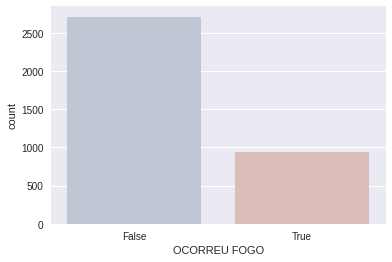

In [ ]:
sns.countplot(data=merjado, x='OCORREU FOGO', palette="vlag")
plt.show()

In [ ]:
merjado.value_counts('OCORREU FOGO', normalize=True)

OCORREU FOGO
False    0.742951
True     0.257049
dtype: float64

25% dos dados correspondem à ocorrência de incêndios.

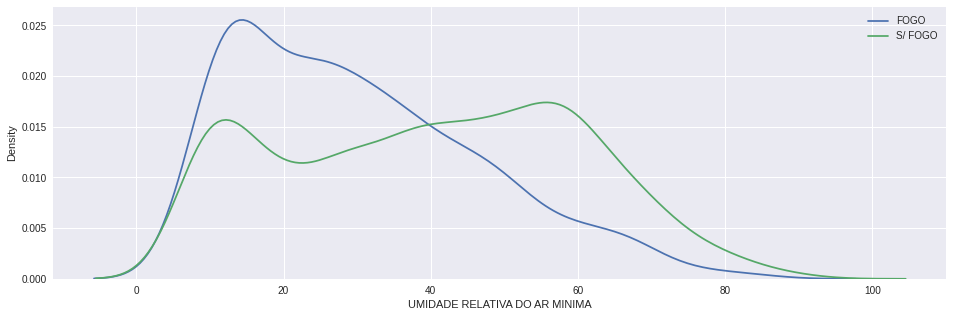

In [ ]:
plt.figure(figsize=(16,5))
sns.kdeplot(merjado[merjado['OCORREU FOGO']==True]['UMIDADE RELATIVA DO AR MINIMA'])
sns.kdeplot(merjado[merjado['OCORREU FOGO']==False]['UMIDADE RELATIVA DO AR MINIMA'])
plt.legend(labels=["FOGO","S/ FOGO"])
plt.show()

A concentração dos focos de incêndios se encontram nas menores taxas de umidade relativa do ar, o que faz sentido

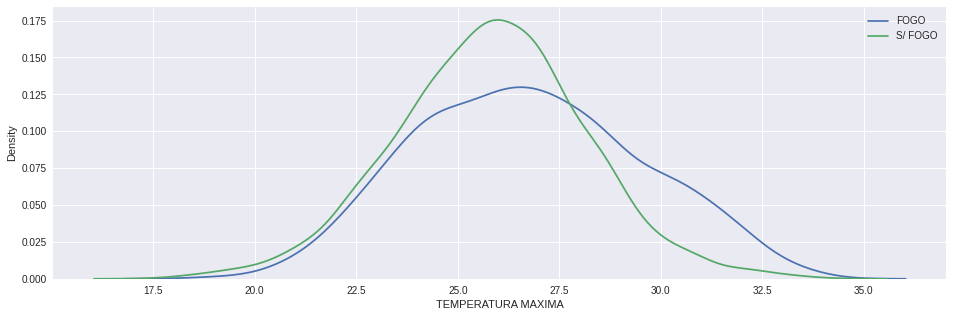

In [ ]:
plt.figure(figsize=(16,5))
sns.kdeplot(merjado[merjado['OCORREU FOGO']==True]['TEMPERATURA MAXIMA'])
sns.kdeplot(merjado[merjado['OCORREU FOGO']==False]['TEMPERATURA MAXIMA'])
plt.legend(labels=["FOGO","S/ FOGO"])
plt.show()

Podemos ver nos dois gráficos acima que a região das maiores temperaturas (28 a 34 graus) predominam os focos de incêndio.

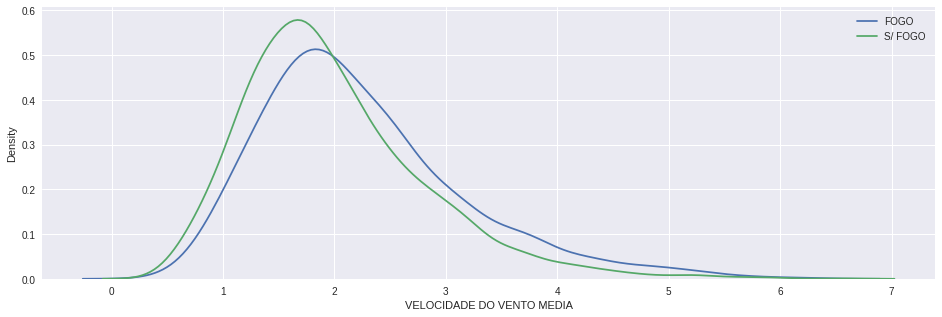

In [ ]:
plt.figure(figsize=(16,5))
sns.kdeplot(merjado[merjado['OCORREU FOGO']==True]['VELOCIDADE DO VENTO MEDIA'])
sns.kdeplot(merjado[merjado['OCORREU FOGO']==False]['VELOCIDADE DO VENTO MEDIA'])
plt.legend(labels=["FOGO","S/ FOGO"])
plt.show()

Incêndios coincidem com maiores velocidades de vento; o vento contribui para a propagação do fogo.

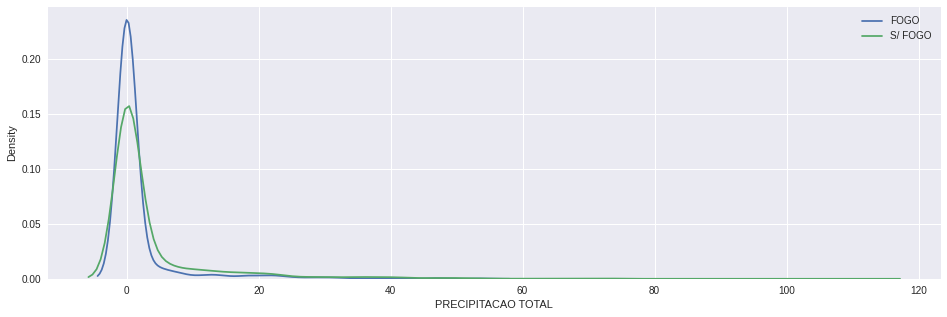

In [ ]:
plt.figure(figsize=(16,5))
sns.kdeplot(merjado[merjado['OCORREU FOGO']==True]['PRECIPITACAO TOTAL'])
sns.kdeplot(merjado[merjado['OCORREU FOGO']==False]['PRECIPITACAO TOTAL'])
plt.legend(labels=["FOGO","S/ FOGO"])
plt.show()

Como a variável DATA está como objeto, temos que transformar para datetime para ser possível plotar graficos para avaliação

In [ ]:
merjado['DATA'] = pd.to_datetime(merjado['DATA'])

In [ ]:
merjado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3653 entries, 0 to 3652
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   DATA                           3653 non-null   datetime64[ns]
 1   PRECIPITACAO TOTAL             3653 non-null   float64       
 2   PRECIPITACAO MEDIA             3653 non-null   float64       
 3   PRESSAO ATMOSFERICA MEDIA      3653 non-null   float64       
 4   RADIACAO GLOBAL MEDIA          3653 non-null   float64       
 5   TEMPERATURA MINIMA             3653 non-null   float64       
 6   TEMPERATURA MAXIMA             3653 non-null   float64       
 7   TEMPERATURA MEDIA              3653 non-null   float64       
 8   PONTO DE ORVALHO MEDIA         3653 non-null   float64       
 9   UMIDADE RELATIVA DO AR MINIMA  3653 non-null   float64       
 10  UMIDADE RELATIVA DO AR MEDIA   3653 non-null   float64       
 11  VELOCIDADE DO VEN

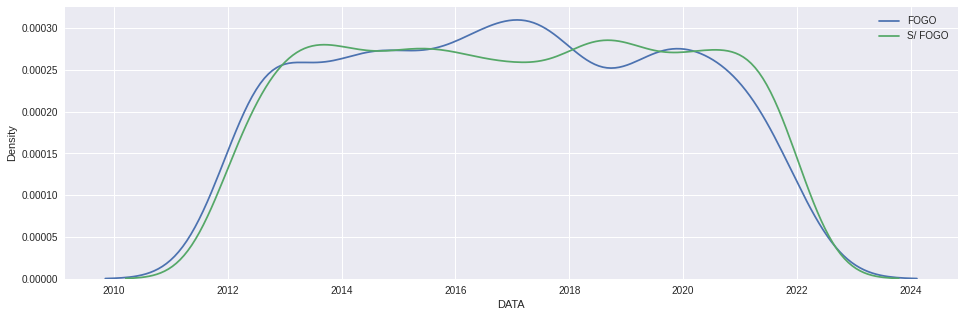

In [ ]:
plt.figure(figsize=(16,5))
sns.kdeplot(merjado[merjado['OCORREU FOGO']==True]['DATA'])
sns.kdeplot(merjado[merjado['OCORREU FOGO']==False]['DATA'])
plt.legend(labels=["FOGO","S/ FOGO"])
plt.show()

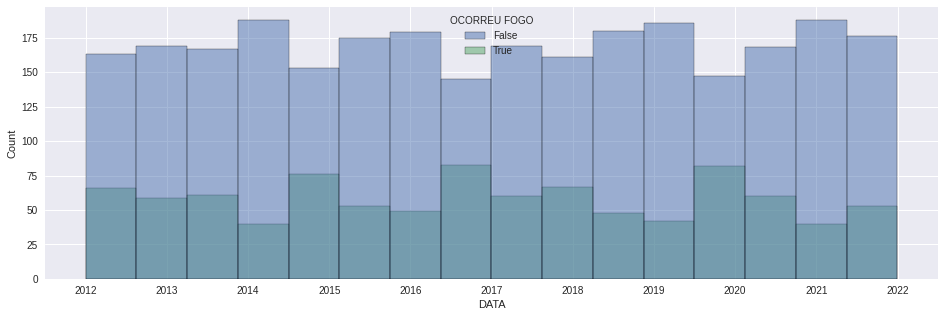

In [ ]:
plt.figure(figsize=(16,5))
sns.histplot(data=merjado, x='DATA', hue='OCORREU FOGO')
plt.show()

Função para plotar gráficos boxplot para todas as variáveis:

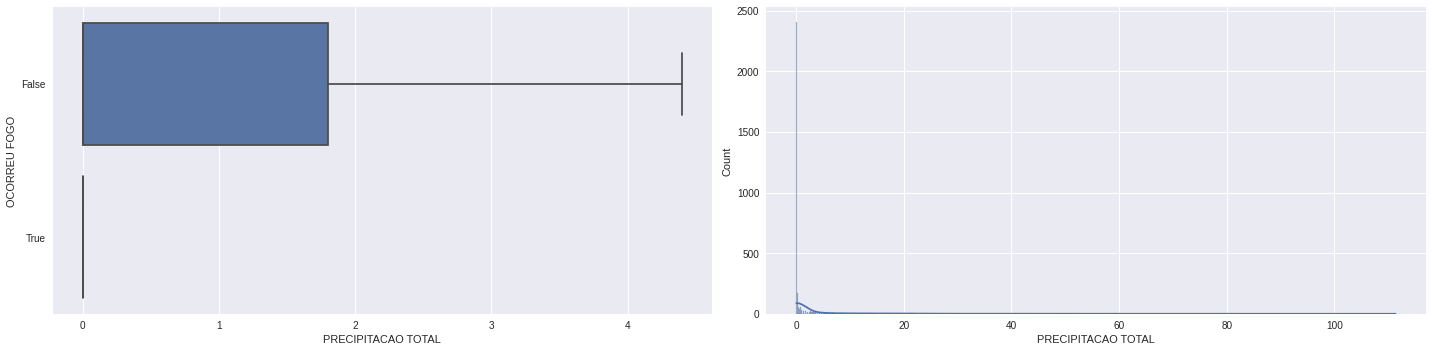

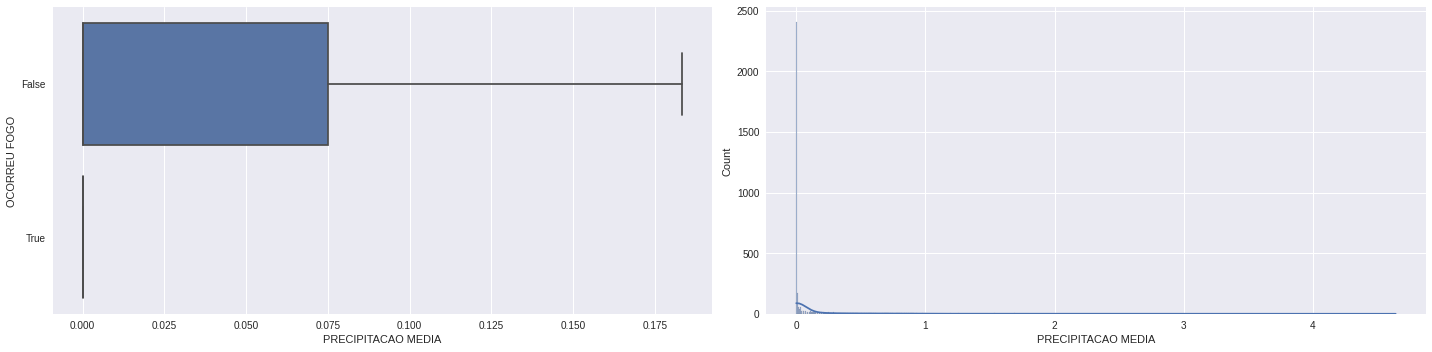

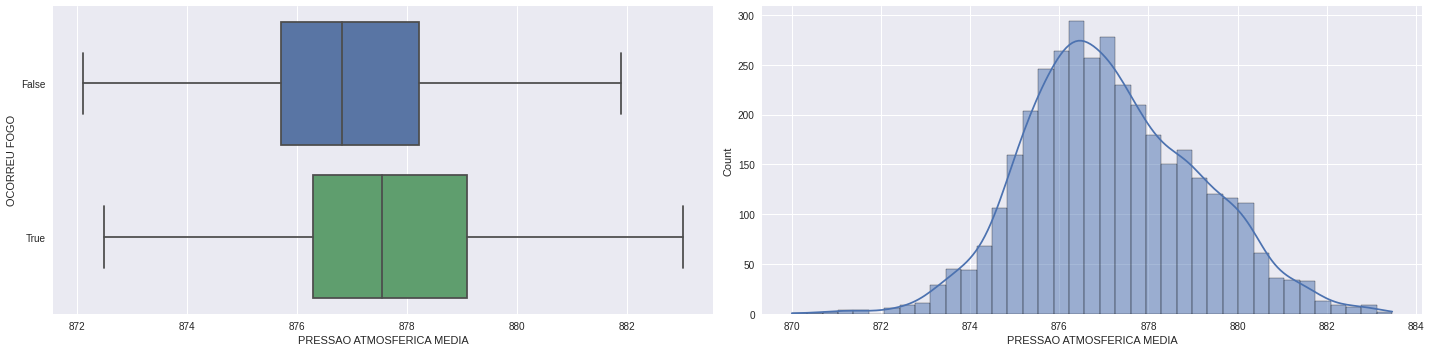

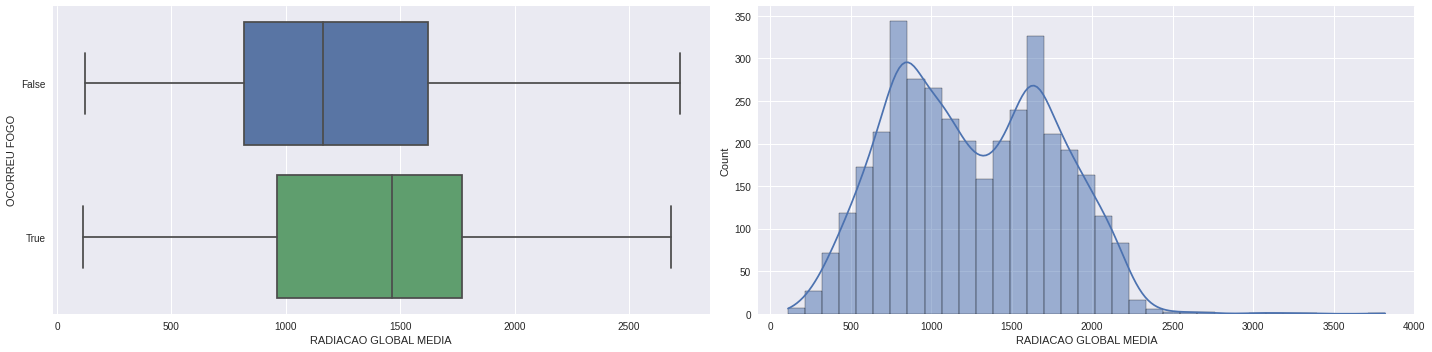

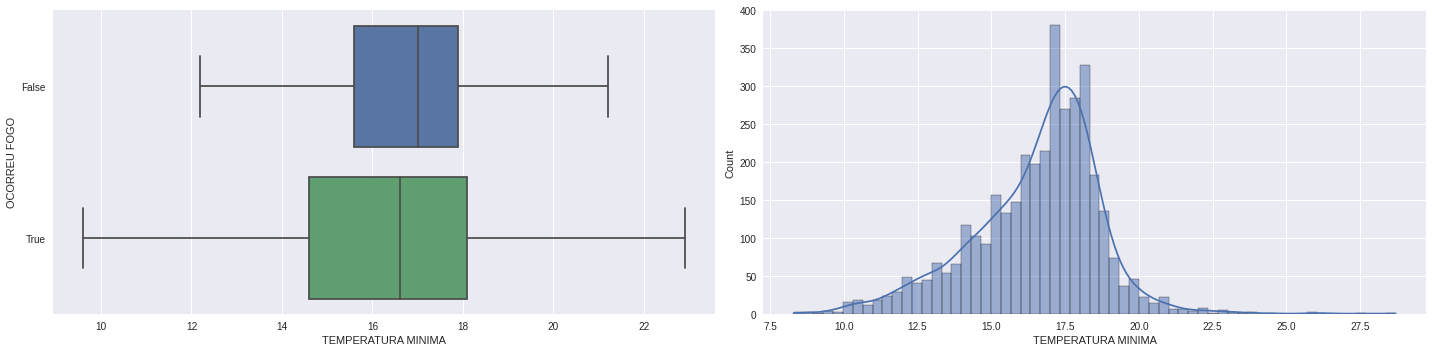

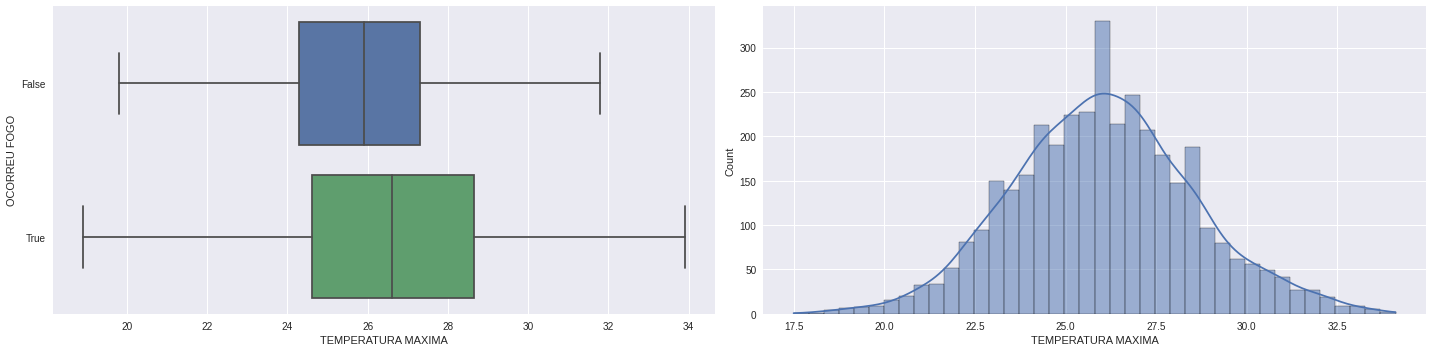

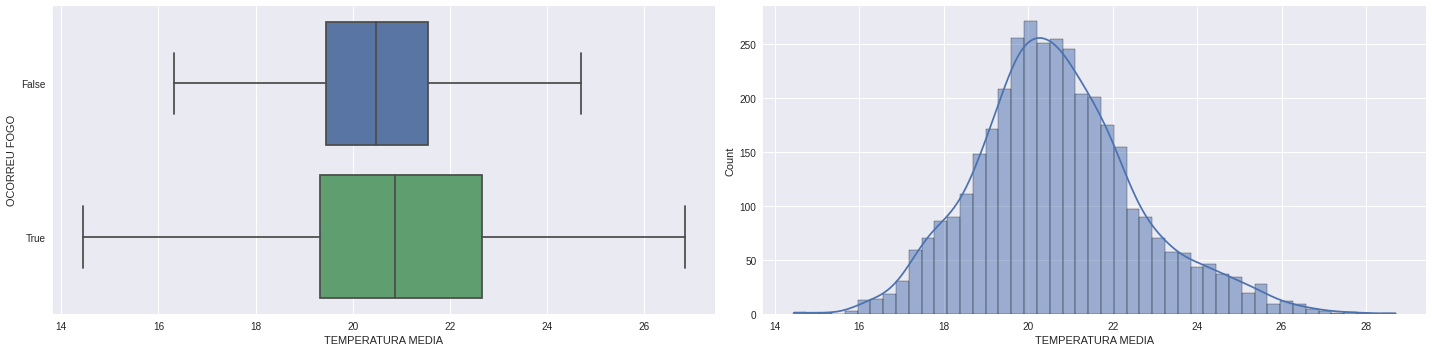

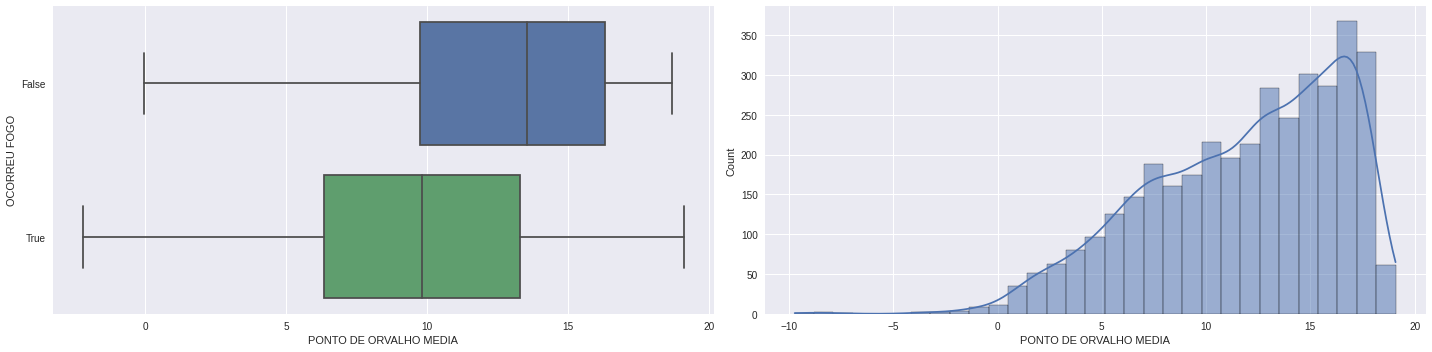

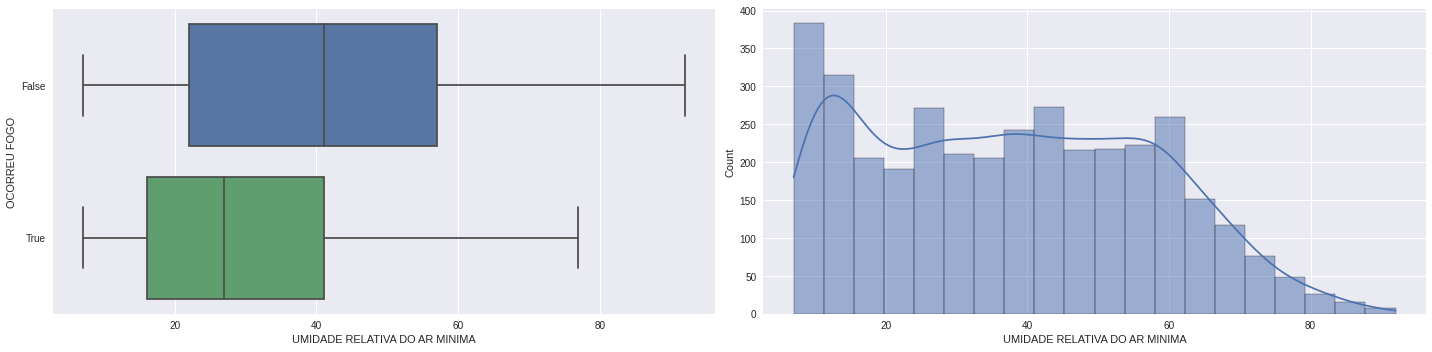

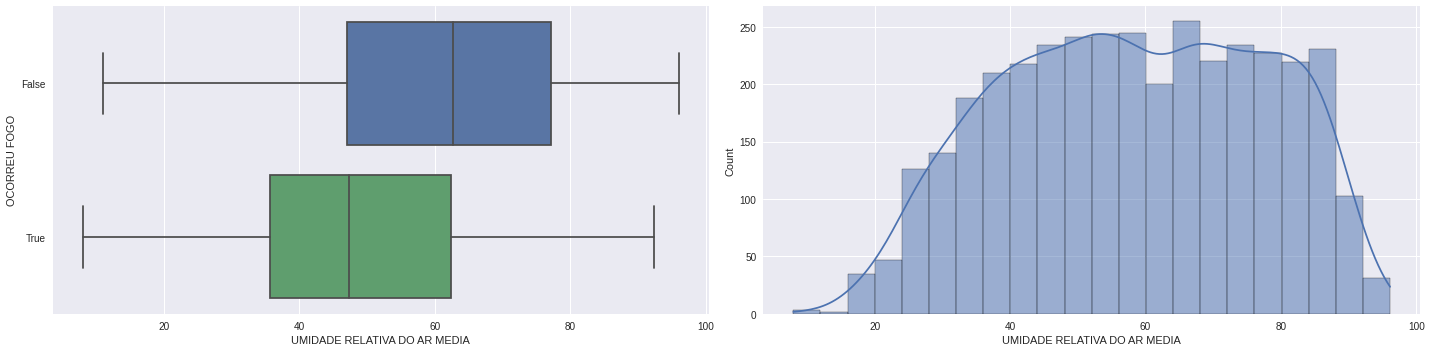

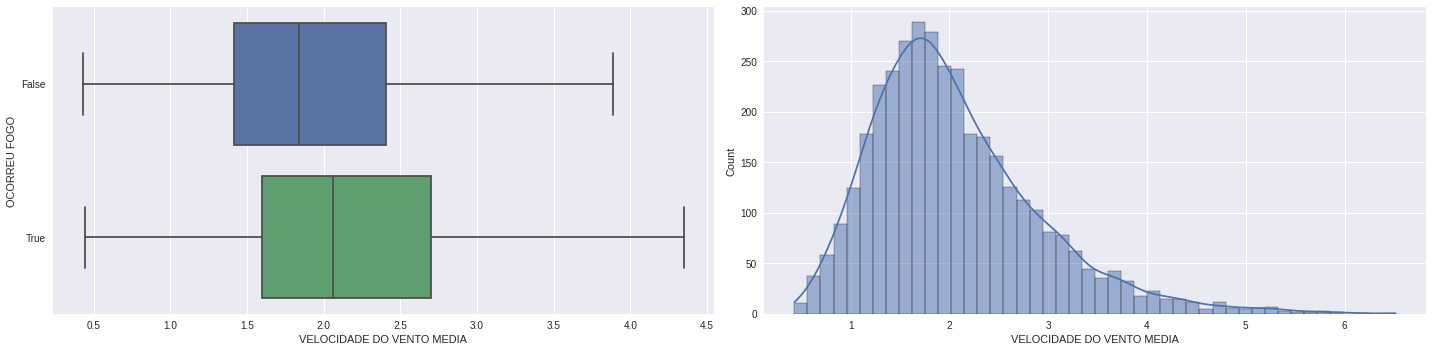

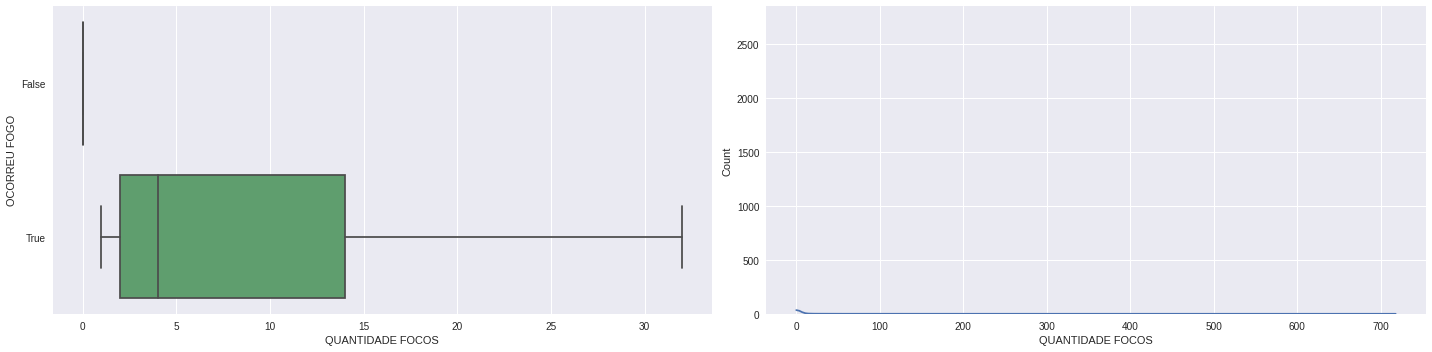

In [ ]:
for col in merjado.columns[1:-1]:
    fig, eixo = plt.subplots(1,2,figsize=(20,5))
    sns.boxplot(data=merjado, x=col, y="OCORREU FOGO", orient='h', ax=eixo[0], showfliers=False)
    sns.histplot(data=merjado, x=col, ax=eixo[1], kde=True)
    plt.tight_layout()
    plt.show()

Com estes gráficos podemos ver que incêndios tem relação com:
- maior pressão atmosférica;
- maior radiação;
- maior temperatura;
- menor ponto de orvalho;
- menos umidade relativa do ar;
- maior velocidade do ar.

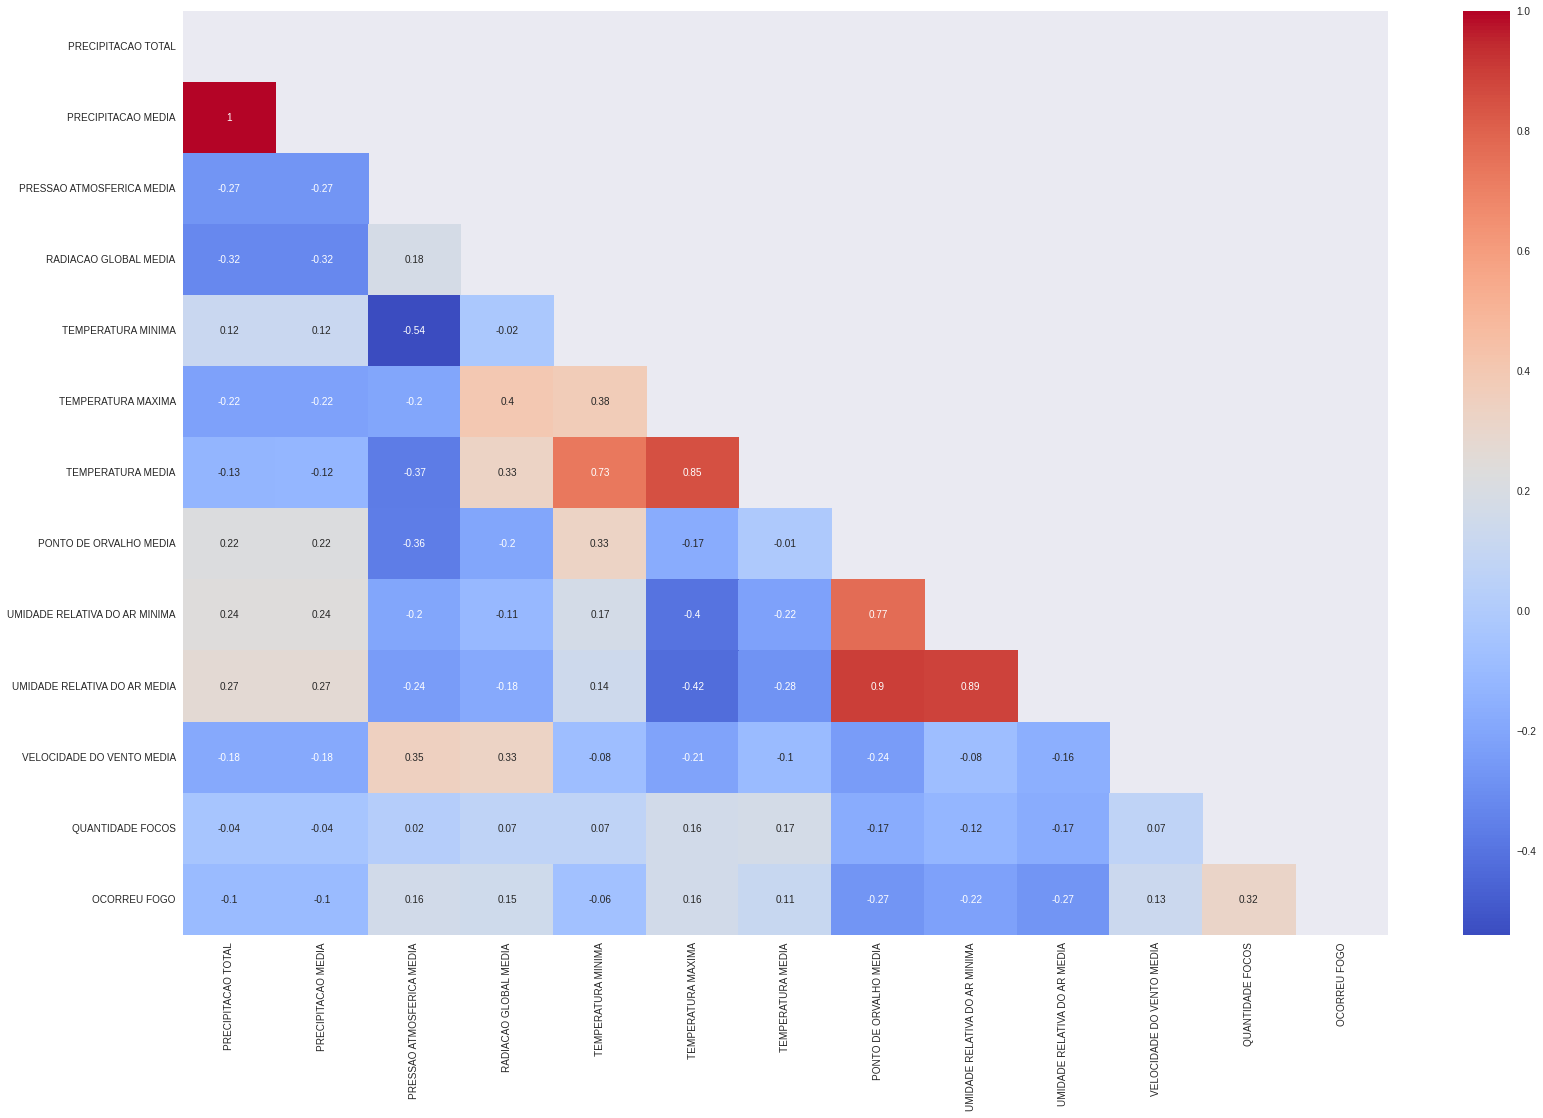

In [ ]:
#Correlação entre as variaveis:

corr = merjado.corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(27,17))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm')
plt.show()

In [ ]:
corr['OCORREU FOGO'].sort_values(ascending=False)[1:]

QUANTIDADE FOCOS                 0.32
PRESSAO ATMOSFERICA MEDIA        0.16
TEMPERATURA MAXIMA               0.16
RADIACAO GLOBAL MEDIA            0.15
VELOCIDADE DO VENTO MEDIA        0.13
TEMPERATURA MEDIA                0.11
TEMPERATURA MINIMA              -0.06
PRECIPITACAO TOTAL              -0.10
PRECIPITACAO MEDIA              -0.10
UMIDADE RELATIVA DO AR MINIMA   -0.22
PONTO DE ORVALHO MEDIA          -0.27
UMIDADE RELATIVA DO AR MEDIA    -0.27
Name: OCORREU FOGO, dtype: float64

Interessante que as variáveis positivas interferem diretamente na ocorrência de incêndios enquanto as negativas interferem de modo oposto; chuva, umidade ajudam a impedir os focos.

## Feature Engineering

Faremos agora a preparação do dataset para criação dos clusters

In [ ]:
cluster_df = merjado.copy()

cluster_df.set_index('DATA', inplace=True)

In [ ]:
cluster_df.head(2)

,PRECIPITACAO TOTAL,PRECIPITACAO MEDIA,PRESSAO ATMOSFERICA MEDIA,RADIACAO GLOBAL MEDIA,TEMPERATURA MINIMA,TEMPERATURA MAXIMA,TEMPERATURA MEDIA,PONTO DE ORVALHO MEDIA,UMIDADE RELATIVA DO AR MINIMA,UMIDADE RELATIVA DO AR MEDIA,VELOCIDADE DO VENTO MEDIA,QUANTIDADE FOCOS,OCORREU FOGO
DATA,,,,,,,,,,,,,
2012-01-01,5.8,0.241667,874.591667,1172.614286,18.4,23.8,20.212500,17.058333,61.0,82.833333,2.175000,0.0,False
2012-01-02,18.2,0.758333,872.995833,374.823077,18.1,19.8,19.116667,16.941667,81.0,87.333333,4.295833,0.0,False


Ajuste de escala para as variáveis numéricas:

In [ ]:
features_cluster = [
    'PRECIPITACAO TOTAL',
    'PRECIPITACAO MEDIA',
    'PRESSAO ATMOSFERICA MEDIA',
    'RADIACAO GLOBAL MEDIA',
    'TEMPERATURA MINIMA',
    'TEMPERATURA MAXIMA',
    'TEMPERATURA MEDIA',
    'PONTO DE ORVALHO MEDIA',
    'UMIDADE RELATIVA DO AR MINIMA',
    'UMIDADE RELATIVA DO AR MEDIA',
    'VELOCIDADE DO VENTO MEDIA',
    'QUANTIDADE FOCOS'
]

In [ ]:
df_cluster = cluster_df[features_cluster]

scaler = RobustScaler()

df_cluster_robust = pd.DataFrame(scaler.fit_transform(df_cluster), index=df_cluster.index, columns=df_cluster.columns)

In [ ]:
df_cluster_robust.head(2)

,PRECIPITACAO TOTAL,PRECIPITACAO MEDIA,PRESSAO ATMOSFERICA MEDIA,RADIACAO GLOBAL MEDIA,TEMPERATURA MINIMA,TEMPERATURA MAXIMA,TEMPERATURA MEDIA,PONTO DE ORVALHO MEDIA,UMIDADE RELATIVA DO AR MINIMA,UMIDADE RELATIVA DO AR MEDIA,VELOCIDADE DO VENTO MEDIA,QUANTIDADE FOCOS
DATA,,,,,,,,,,,,
2012-01-01,5.8,5.8,-0.900312,-0.060607,0.538462,-0.6875,-0.133452,0.598774,0.705882,0.792076,0.270161,0.0
2012-01-02,18.2,18.2,-1.496885,-1.037011,0.423077,-1.9375,-0.601423,0.582811,1.294118,0.937559,2.322581,0.0


In [ ]:
df_cluster_robust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3653 entries, 2012-01-01 to 2021-12-31
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PRECIPITACAO TOTAL             3653 non-null   float64
 1   PRECIPITACAO MEDIA             3653 non-null   float64
 2   PRESSAO ATMOSFERICA MEDIA      3653 non-null   float64
 3   RADIACAO GLOBAL MEDIA          3653 non-null   float64
 4   TEMPERATURA MINIMA             3653 non-null   float64
 5   TEMPERATURA MAXIMA             3653 non-null   float64
 6   TEMPERATURA MEDIA              3653 non-null   float64
 7   PONTO DE ORVALHO MEDIA         3653 non-null   float64
 8   UMIDADE RELATIVA DO AR MINIMA  3653 non-null   float64
 9   UMIDADE RELATIVA DO AR MEDIA   3653 non-null   float64
 10  VELOCIDADE DO VENTO MEDIA      3653 non-null   float64
 11  QUANTIDADE FOCOS               3653 non-null   float64
dtypes: float64(12)
memory usage: 371.0+ KB

In [ ]:
df_cluster_robust.describe()

,PRECIPITACAO TOTAL,PRECIPITACAO MEDIA,PRESSAO ATMOSFERICA MEDIA,RADIACAO GLOBAL MEDIA,TEMPERATURA MINIMA,TEMPERATURA MAXIMA,TEMPERATURA MEDIA,PONTO DE ORVALHO MEDIA,UMIDADE RELATIVA DO AR MINIMA,UMIDADE RELATIVA DO AR MEDIA,VELOCIDADE DO VENTO MEDIA,QUANTIDADE FOCOS
count,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000
mean,3.189105,3.207391,0.066888,0.045448,-0.175767,0.013439,0.064858,-0.112720,0.016819,-0.002297,0.156157,4.697783
std,8.653948,8.707125,0.721731,0.611638,0.830568,0.784070,0.824420,0.634633,0.584808,0.613783,0.828976,25.136126
min,0.000000,0.000000,-2.618380,-1.359176,-3.346154,-2.656250,-2.597865,-3.067132,-0.882353,-1.627258,-1.419355,0.000000
25%,0.000000,0.000000,-0.437695,-0.466429,-0.653846,-0.500000,-0.462633,-0.577395,-0.500000,-0.488114,-0.419355,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.562305,0.533571,0.346154,0.500000,0.537367,0.422605,0.500000,0.511886,0.580645,1.000000
max,111.400000,111.400000,2.419003,3.179364,4.500000,2.531250,3.491103,0.876425,1.617647,1.221791,4.471774,718.000000


## Redução de Dimensionalidade

**PCA**

In [ ]:
pca_rs = PCA(n_components=5)
pca_rs.fit(df_cluster_robust)

PCA(n_components=5)

In [ ]:
res_pca_rs = pca_rs.fit_transform(df_cluster_robust)

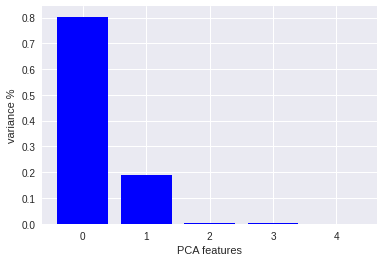

In [ ]:
features = range(pca_rs.n_components_)
plt.bar(features, pca_rs.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

df_pca_rs = pd.DataFrame(res_pca_rs, index=df_cluster_robust.index, columns=[
    'PC'+(str(n+1)) for n in range(pca_rs.n_components_)])

In [ ]:
df_pca_rs.head(2)

,PC1,PC2,PC3,PC4,PC5
DATA,,,,,
2012-01-01,-4.798664,3.617643,-0.240864,1.512221,0.572309
2012-01-02,-5.238807,21.164570,0.992687,1.516870,2.267791


**TSNE**

In [ ]:
tsne_rs = TSNE(learning_rate=50, n_components=2)
tsne_rs.fit(df_cluster_robust)

TSNE(learning_rate=50)

In [ ]:
res_tsne_rs = tsne_rs.fit_transform(df_cluster_robust)
print(res_tsne_rs.shape)

(3653, 2)


In [ ]:
df_tsne_rs = pd.DataFrame(res_tsne_rs, index=df_cluster.index, columns=['tsne1', 'tsne2'])

In [ ]:
df_tsne_rs.head(2)

,tsne1,tsne2
DATA,,
2012-01-01,30.790916,-41.228493
2012-01-02,-4.459044,-62.908489


## Segmentação

Serão investigadas diferentes formas de se identificar o número de clusters ideal

In [ ]:
def elbowplot(df, elbowmetric, model):
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    vis = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  

In [ ]:
def elbowplot_metrics(df):
    # call elbow plot for each of 3 alternative metrics
    # distortion = mean sum of squared distances to center
    # silhouette = mean ratio of intra-cluster and nearest-cluster distance
    # calinski = ratio of within to between cluster dispersion
    
    model = KMeans(random_state=RNDN)
    _ = [elbowplot(df, m, model) for m in tqdm(["distortion", "silhouette", "calinski_harabasz"])]

In [ ]:
def inertia_plot(df):
    # kmeans: looking for the elbow - compare number of clusters by their inertia scores

    # run kMeans for alternative number of clusters k
    inertia_scores = [KMeans(
                    n_clusters=k, 
                    init='k-means++', 
                    n_init=10, max_iter=100, random_state=RNDN). \
                    fit(df).inertia_ \
                    for k in range(2,nK)]
    

    dict_inertia = dict(zip(range(2,nK), inertia_scores))

    # scree plot: look for elbow
    plt.figure(figsize=[8,5])
    plt.plot(range(2,nK), inertia_scores, color="blue")
    plt.title("inertia (sum of squared errors) vs. number of clusters")
    plt.xticks(np.arange(2,nK,1.0))
    plt.xlabel("number of clusters K")
    plt.ylabel("inertia");
    
    return(inertia_scores)

In [ ]:
def find_Knee(df, inertia_scores):
    # inertia scores: confirm visual clue of elbow plot
    # KneeLocator class will detect elbows if curve is convex; if concavem will detect knees
    inertia_knee_a3 = KneeLocator(
        range(2,nK), 
        inertia_scores, 
        S=0.1, curve="convex", direction="decreasing")

    K_inertia_a3 = inertia_knee_a3.elbow 
    print("elbow at k =", f'{K_inertia_a3:.0f} clusters')

In [ ]:
def find_silhuette_score(df):

    # find maximum silhouette score for up to kN clusters
    sil_scores = [silhouette_score(
                                df, 
                                KMeans(n_clusters=k, random_state=RNDN). \
                                fit_predict(df)) \
                                for k in tqdm(range(2,nK))]

    dict_sil = dict(zip(range(2,nK), sil_scores))
    print("silhouette scores:")
    _ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
    K_sil_a3 = max(dict_sil, key=dict_sil.get)            # optimal clusters
    sil_opt_a3 = dict_sil[K_sil_a3]                       # optimal silhouette score
    print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

    plt.figure(figsize=[7,5])
    plt.plot(range(2,nK), sil_scores, color="red")
    plt.title("silhouette scores vs. number of clusters")
    plt.xticks(np.arange(2,nK,1))
    plt.xlabel("number of clusters K")
    plt.ylabel("silhouette score")
    plt.show()

In [ ]:
def complete_silhouettes(df):
    # silhouette score plots with Yellowbrick
    dict_score = dict()
    fig, ax = plt.subplots(int(np.ceil(nK/2)-1), 2, figsize=(15,30))

    for i in tqdm(range(2,nK)):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=RNDN)
        q, mod = divmod(i, 2)
        vis = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod], is_fitted=False)
        vis.fit(df)
        vis.finalize()
        dict_score[i] = vis.silhouette_score_


    print("silhouette scores for k clusters:")
    _ = [print(k,":",f'{v:.3f}') for k,v in dict_score.items()]

    K_sil_a3 = max(dict_score, key=dict_score.get)          # optimal clusters
    sil_opt_a3 = dict_score[K_sil_a3]                       # optimal (maximal) silhouette score
    print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

Avaliaremos entre 2 e 11 clusters, utilizando um random_state=42

In [ ]:
RNDN = 42                   # random state
nK = 12                     # initial guess: clusters

**PCA**

  0%|          | 0/3 [00:00<?, ?it/s]

Elbow Score Plot (distortion metric):
elbow value = optimal k: 5  | elbow score: 415,290.404


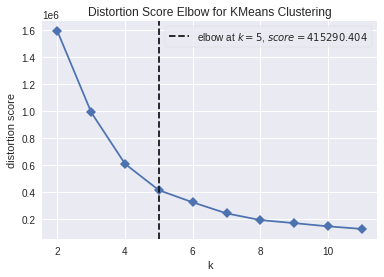

 33%|███▎      | 1/3 [00:03<00:06,  3.36s/it]

Elbow Score Plot (silhouette metric):
elbow value = optimal k: 2  | elbow score: 0.916


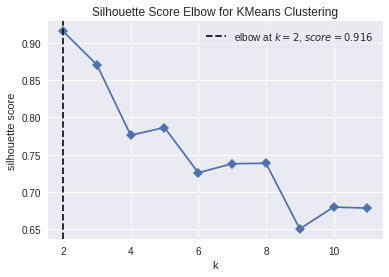

 67%|██████▋   | 2/3 [00:08<00:04,  4.67s/it]

Elbow Score Plot (calinski_harabasz metric):
elbow value = optimal k: 8  | elbow score: 7,168.652


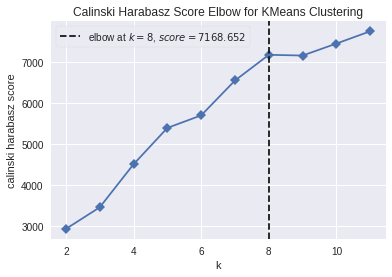

100%|██████████| 3/3 [00:11<00:00,  3.85s/it]


In [ ]:
elbowplot_metrics(df_pca_rs)

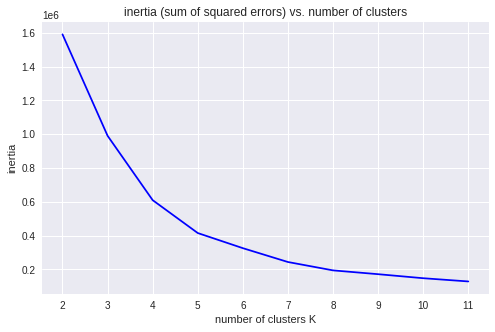

In [ ]:
inertia_scores_rs_pca = inertia_plot(df_pca_rs)

In [ ]:
find_Knee(df_pca_rs, inertia_scores_rs_pca)

elbow at k = 5 clusters


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


silhouette scores:
2 : 0.916
3 : 0.871
4 : 0.776
5 : 0.786
6 : 0.726
7 : 0.738
8 : 0.739
9 : 0.651
10 : 0.680
11 : 0.678
maximum silhouette score for 2 clusters:  0.916


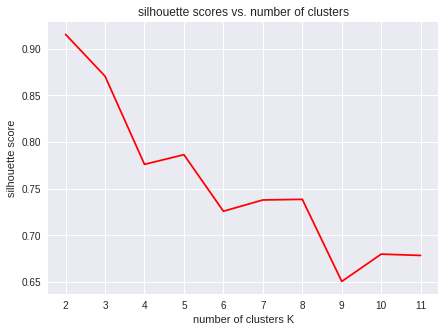

In [ ]:
find_silhuette_score(df_pca_rs)

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


silhouette scores for k clusters:
2 : 0.916
3 : 0.871
4 : 0.776
5 : 0.786
6 : 0.726
7 : 0.738
8 : 0.739
9 : 0.651
10 : 0.680
11 : 0.678
maximum silhouette score for 2 clusters:  0.916


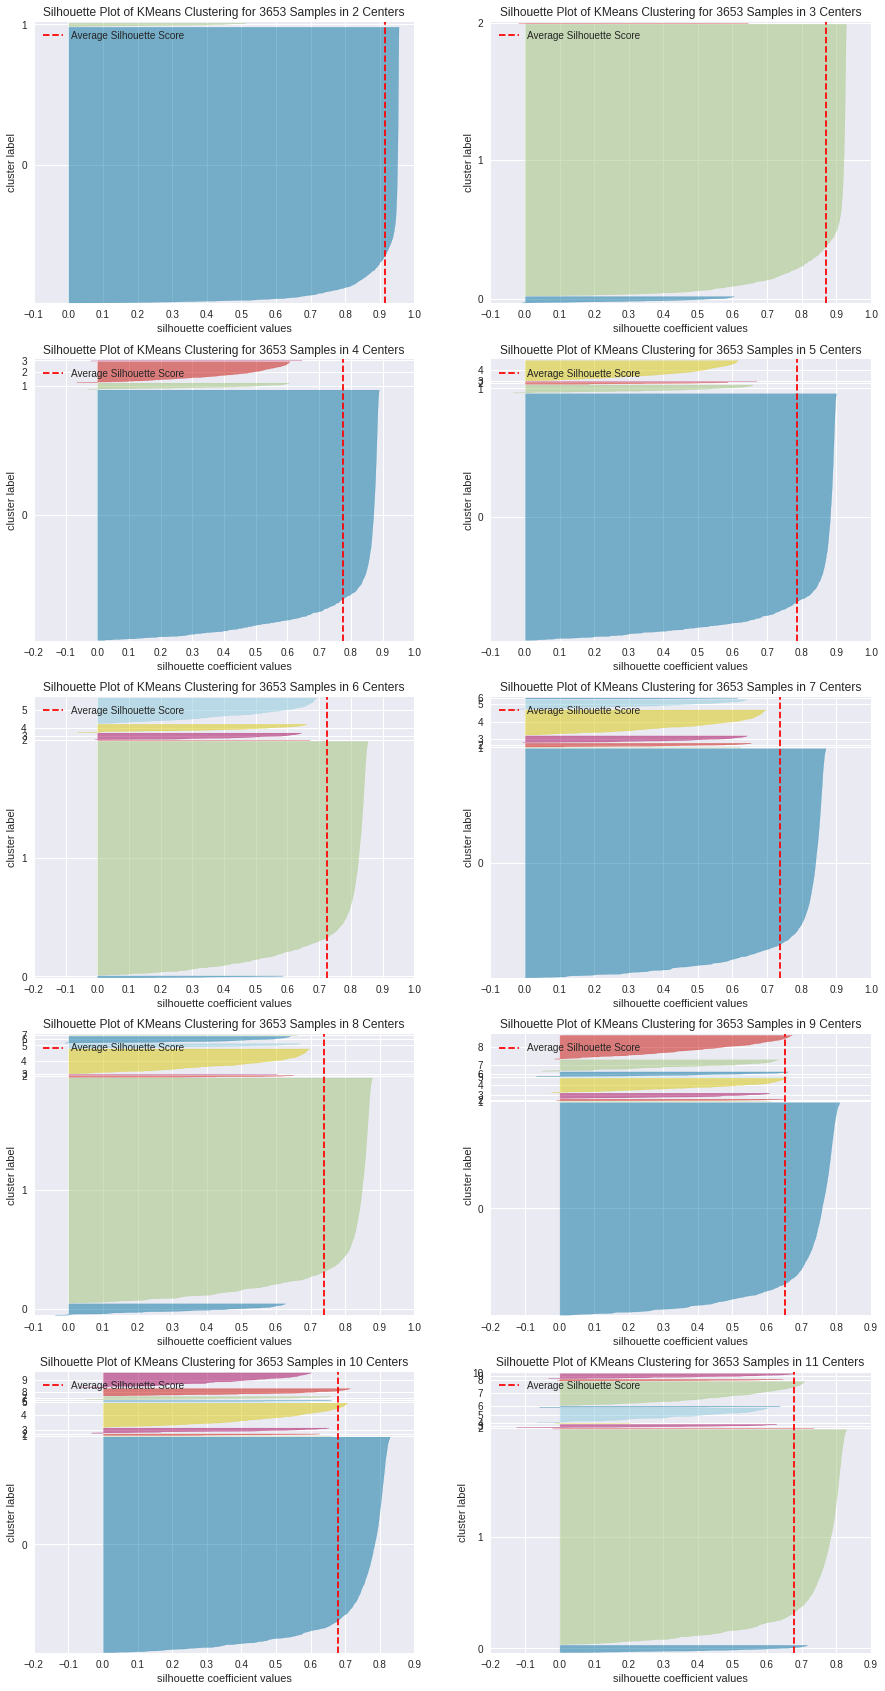

In [ ]:
complete_silhouettes(df_pca_rs)

**TSNE**

  0%|          | 0/3 [00:00<?, ?it/s]

Elbow Score Plot (distortion metric):
elbow value = optimal k: 5  | elbow score: 1,046,494.797


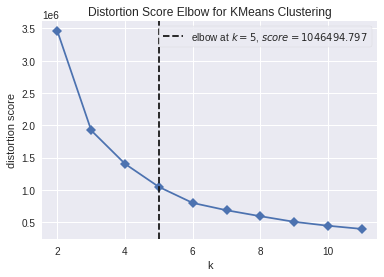

 33%|███▎      | 1/3 [00:01<00:03,  1.99s/it]

Elbow Score Plot (silhouette metric):
elbow value = optimal k: 3  | elbow score: 0.437


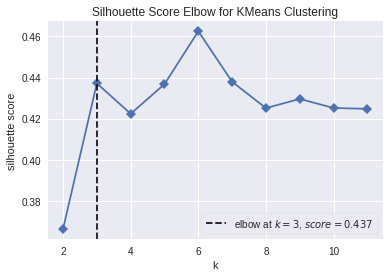

 67%|██████▋   | 2/3 [00:06<00:03,  3.28s/it]

Elbow Score Plot (calinski_harabasz metric):
elbow value = optimal k: 6  | elbow score: 4,405.473


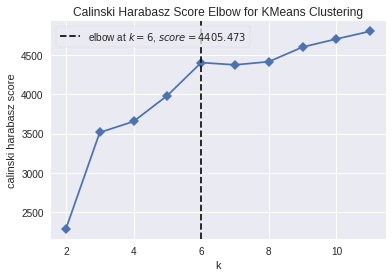

100%|██████████| 3/3 [00:07<00:00,  2.66s/it]


In [ ]:
elbowplot_metrics(df_tsne_rs)

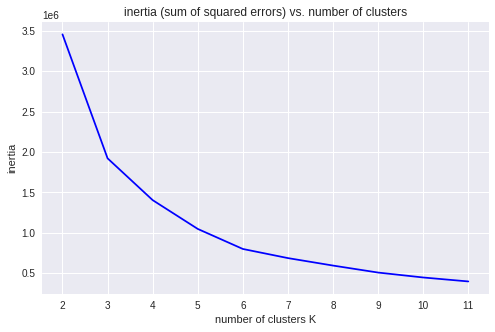

In [ ]:
inertia_scores_rs_tsne = inertia_plot(df_tsne_rs)

In [ ]:
find_Knee(df_tsne_rs, inertia_scores_rs_tsne)

elbow at k = 5 clusters


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

silhouette scores:
2 : 0.366
3 : 0.437
4 : 0.422
5 : 0.437
6 : 0.463
7 : 0.438
8 : 0.425
9 : 0.430
10 : 0.425
11 : 0.425
maximum silhouette score for 6 clusters:  0.463


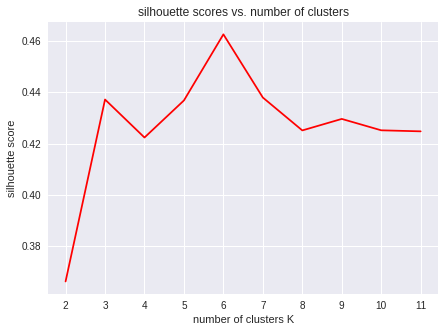

In [ ]:
find_silhuette_score(df_tsne_rs)

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


silhouette scores for k clusters:
2 : 0.366
3 : 0.437
4 : 0.422
5 : 0.437
6 : 0.463
7 : 0.438
8 : 0.425
9 : 0.430
10 : 0.425
11 : 0.425
maximum silhouette score for 6 clusters:  0.463


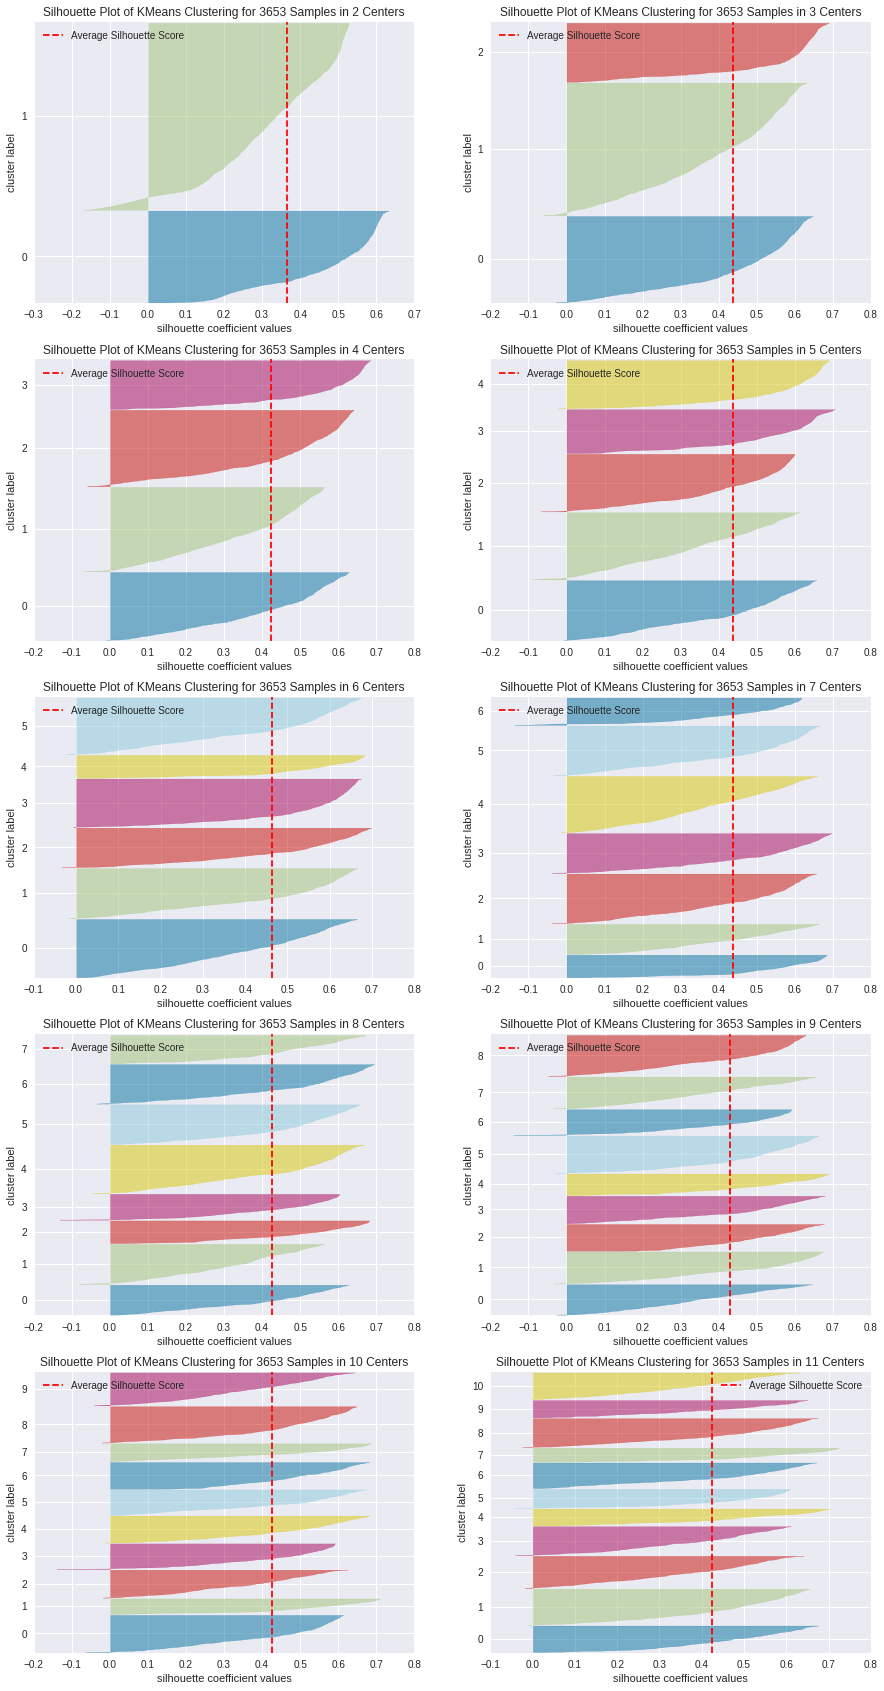

In [ ]:
complete_silhouettes(df_tsne_rs)

Seguiremos a segmentação com:

*   k = 6
*   df = df_tsne_rs

In [ ]:
K=6
df_selected = df_tsne_rs

KMeans:

In [ ]:
model_kmeans = KMeans(n_clusters=K, random_state=RNDN)
res_kmeans = model_kmeans.fit_predict(df_selected)

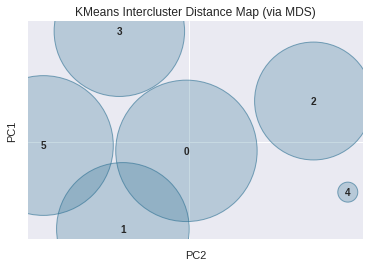

In [ ]:
# optimal number of clusters: intercluster distances
visD = InterclusterDistance(
    model_kmeans, max_size=20000, legend=False, random_state=RNDN)
visD.fit(df_selected)
visD.finalize();

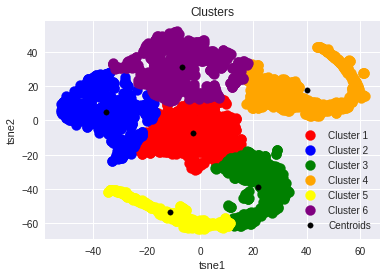

In [ ]:
df_values = df_selected.values
plt.scatter(df_values[res_kmeans == 0, 0], df_values[res_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(df_values[res_kmeans == 1, 0], df_values[res_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(df_values[res_kmeans == 2, 0], df_values[res_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(df_values[res_kmeans == 3, 0], df_values[res_kmeans == 3, 1], s = 100, c = 'orange', label = 'Cluster 4')
plt.scatter(df_values[res_kmeans == 4, 0], df_values[res_kmeans == 4, 1], s = 100, c = 'yellow', label = 'Cluster 5')
plt.scatter(df_values[res_kmeans == 5, 0], df_values[res_kmeans == 5, 1], s = 100, c = 'purple', label = 'Cluster 6')
plt.scatter(model_kmeans.cluster_centers_[:, 0], model_kmeans.cluster_centers_[:, 1], s = 30, c = 'black', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend()
plt.show()

Resultados:

In [ ]:
final_df = cluster_df.copy()

In [ ]:
final_df['Cluster']=res_kmeans

In [ ]:
sil_final = silhouette_score(df_selected, final_df["Cluster"])
print("silhouette score", f'{sil_final:.3f}')

silhouette score 0.463


In [ ]:
final_df.head(2)

,PRECIPITACAO TOTAL,PRECIPITACAO MEDIA,PRESSAO ATMOSFERICA MEDIA,RADIACAO GLOBAL MEDIA,TEMPERATURA MINIMA,TEMPERATURA MAXIMA,TEMPERATURA MEDIA,PONTO DE ORVALHO MEDIA,UMIDADE RELATIVA DO AR MINIMA,UMIDADE RELATIVA DO AR MEDIA,VELOCIDADE DO VENTO MEDIA,QUANTIDADE FOCOS,OCORREU FOGO,Cluster
DATA,,,,,,,,,,,,,,
2012-01-01,5.8,0.241667,874.591667,1172.614286,18.4,23.8,20.212500,17.058333,61.0,82.833333,2.175000,0.0,False,2
2012-01-02,18.2,0.758333,872.995833,374.823077,18.1,19.8,19.116667,16.941667,81.0,87.333333,4.295833,0.0,False,4


## Resultados

In [ ]:
object_list = ['OCORREU FOGO']
numeric_list = ['PRECIPITACAO TOTAL',
    'PRECIPITACAO MEDIA',
    'PRESSAO ATMOSFERICA MEDIA',
    'RADIACAO GLOBAL MEDIA',
    'TEMPERATURA MINIMA',
    'TEMPERATURA MAXIMA',
    'TEMPERATURA MEDIA',
    'PONTO DE ORVALHO MEDIA',
    'UMIDADE RELATIVA DO AR MINIMA',
    'UMIDADE RELATIVA DO AR MEDIA',
    'VELOCIDADE DO VENTO MEDIA',
    'QUANTIDADE FOCOS']

In [ ]:
def cluster_pies(df):
    
    # number of categorical variables
    cat_features = ['OCORREU FOGO']

    c = len(cat_features)
    
    # number of clusters
    K = df["Cluster"].nunique()

    for k in tqdm(range(K)):
        dfc = df[df["Cluster"]==k]
        radiacao = dfc["RADIACAO GLOBAL MEDIA"].median()
        temperatura = dfc["TEMPERATURA MAXIMA"].median()
        umidade = dfc["UMIDADE RELATIVA DO AR MEDIA"].median()
        cases = dfc.shape[0]

        fig = plt.figure(figsize=(20, 8))
        fig.suptitle("Cluster " + str(k) + ": " + \
            f'{cases:,.0f}' + " cases | " + \
            "median radiacao " + f'{radiacao:.2f}' + \
            " | median temperatura " + f'{temperatura:.2f}' + \
            " | median umidade " + f'{umidade:.0f}')

        ax1 = plt.subplot2grid((2,c),(0,0))
        plt.pie(dfc["OCORREU FOGO"].value_counts(), labels=dfc["OCORREU FOGO"].value_counts().index)
        plt.title("OCORREU FOGO");

In [ ]:
def plot_cluster_features(df):
    for column in df.columns[1:]:
        if column in object_list:
            plt.figure(figsize=(20, 4))
            sns.countplot(data=df, hue=column, x='Cluster')
        if column in numeric_list:
            plt.figure(figsize=(20, 4))
            sns.boxplot(data=df, y=column, x='Cluster', showfliers=False)

In [ ]:
# helper function: medians and modes for each cluster
def cluster_profile(df):
    dfc = df.groupby("Cluster").agg({
        "PRECIPITACAO TOTAL": "median",
        "PRECIPITACAO MEDIA": "median",
        "PRESSAO ATMOSFERICA MEDIA": "median",
        "RADIACAO GLOBAL MEDIA": "median",
        "TEMPERATURA MINIMA": "median",
        "TEMPERATURA MAXIMA": "median",
        "TEMPERATURA MEDIA": "median",
        "PONTO DE ORVALHO MEDIA": "median",
        "UMIDADE RELATIVA DO AR MINIMA": "median",
        "UMIDADE RELATIVA DO AR MEDIA": "median",
        "VELOCIDADE DO VENTO MEDIA": "median",
        "QUANTIDADE FOCOS": "median",
        "OCORREU FOGO": lambda x: x.value_counts().index[0],
    })    
    
    cluster_pies(df)
    plot_cluster_features(df)
    return dfc

100%|██████████| 6/6 [00:00<00:00, 47.92it/s]


Cluster,0,1,2,3,4,5
PRECIPITACAO TOTAL,0.0,0.0,4.8,0.0,21.9,0.0
PRECIPITACAO MEDIA,0.0,0.0,0.2,0.0,0.920833,0.0
PRESSAO ATMOSFERICA MEDIA,876.55625,876.53125,875.991667,877.714583,875.716667,879.183333
RADIACAO GLOBAL MEDIA,1359.53042,1222.134615,909.961538,1544.45,725.870673,1455.916667
TEMPERATURA MINIMA,17.3,17.6,17.4,16.5,17.35,14.2
TEMPERATURA MAXIMA,26.0,28.2,25.4,27.1,24.55,24.7
TEMPERATURA MEDIA,20.964583,22.233333,20.354167,21.052083,19.84375,19.0125
PONTO DE ORVALHO MEDIA,15.970018,10.829167,16.0,8.783333,16.108333,9.382576
UMIDADE RELATIVA DO AR MINIMA,55.0,20.0,52.0,25.0,58.0,31.0
UMIDADE RELATIVA DO AR MEDIA,74.8125,44.393382,75.173913,44.154762,78.708333,50.8125


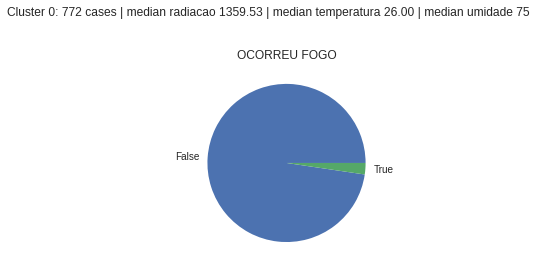

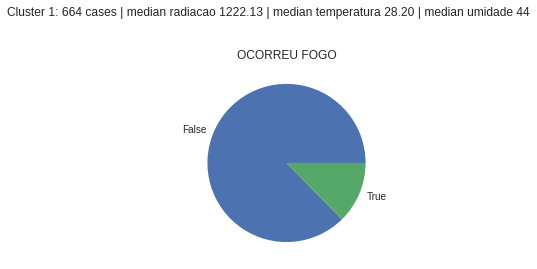

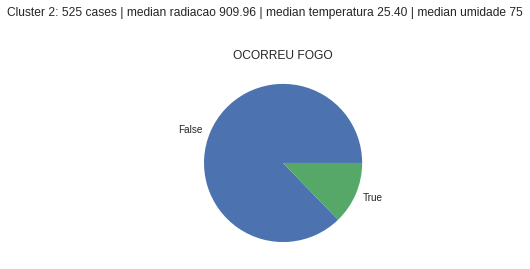

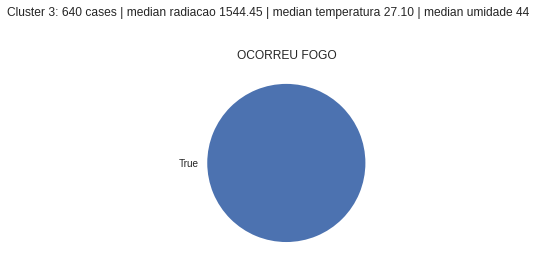

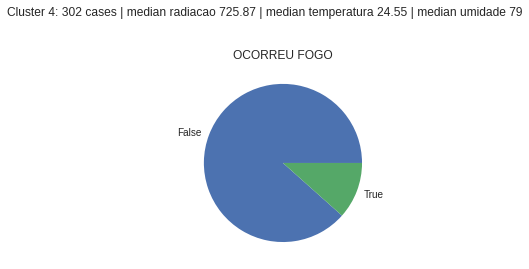

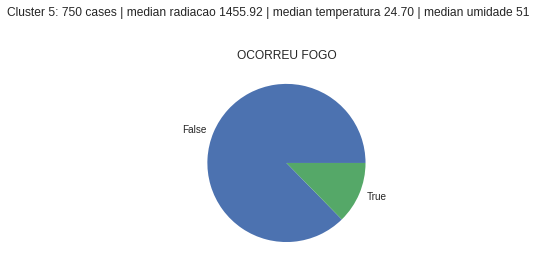

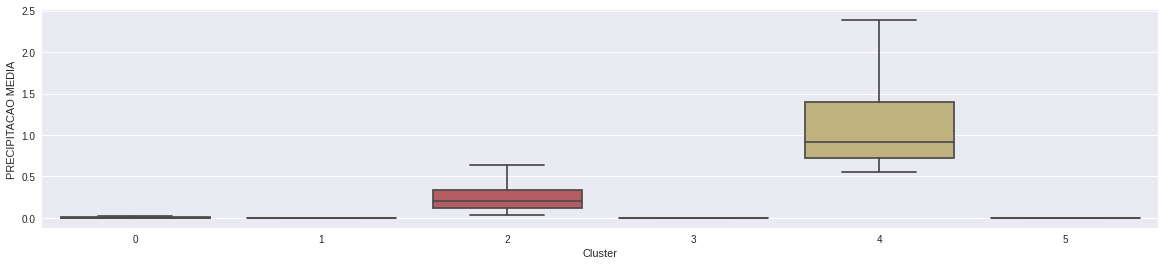

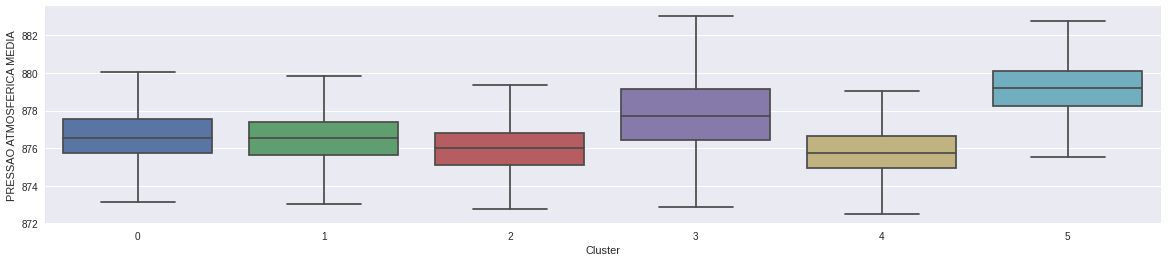

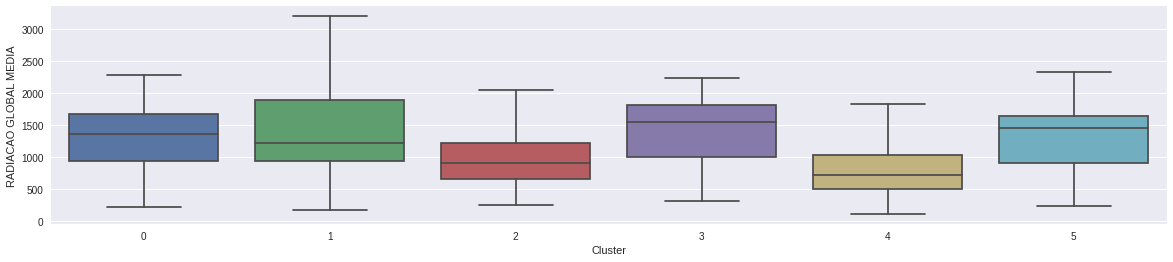

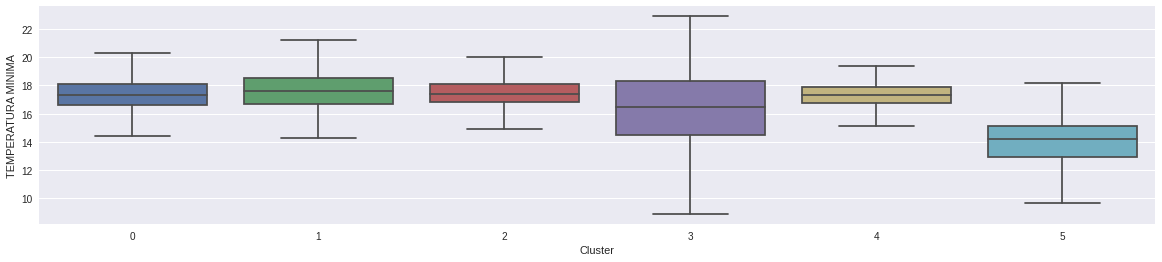

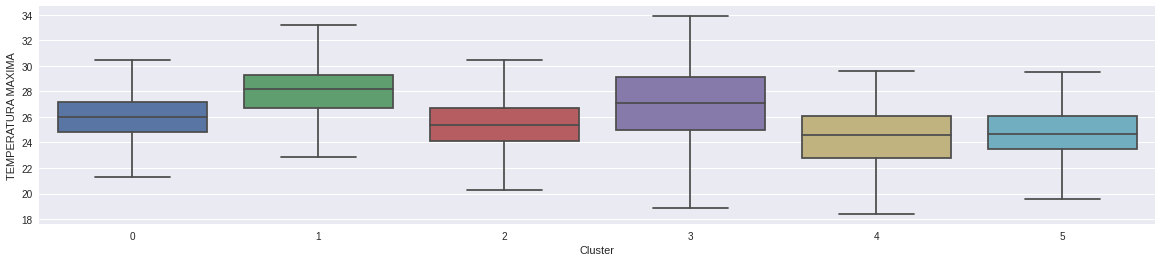

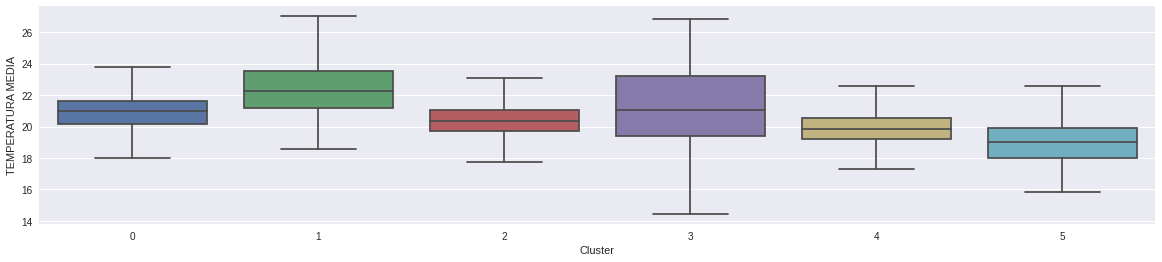

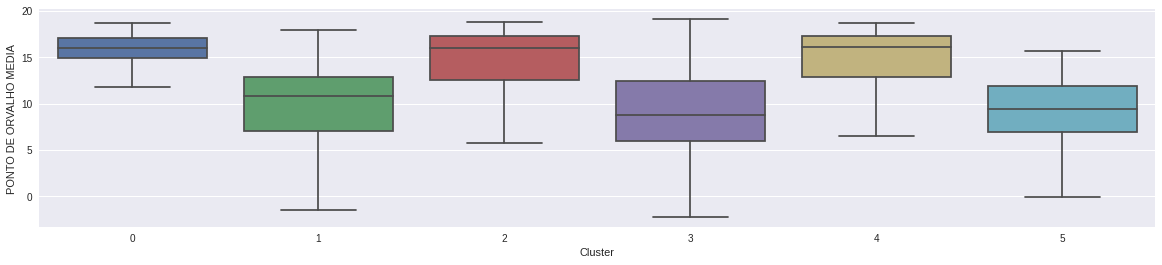

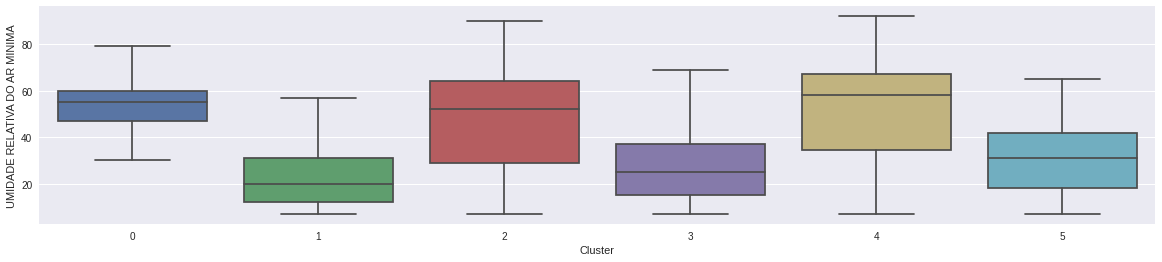

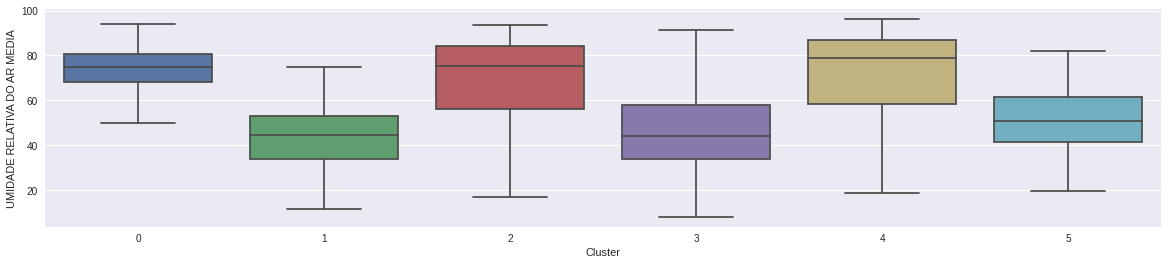

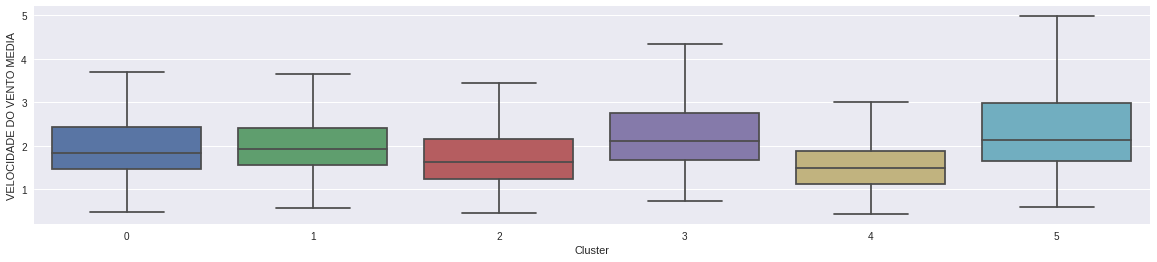

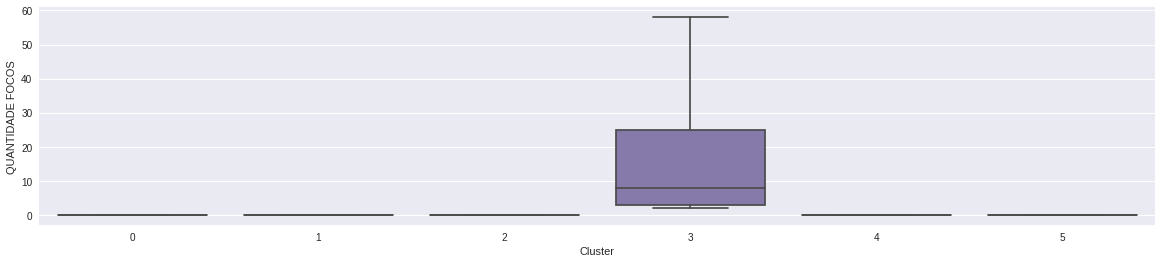

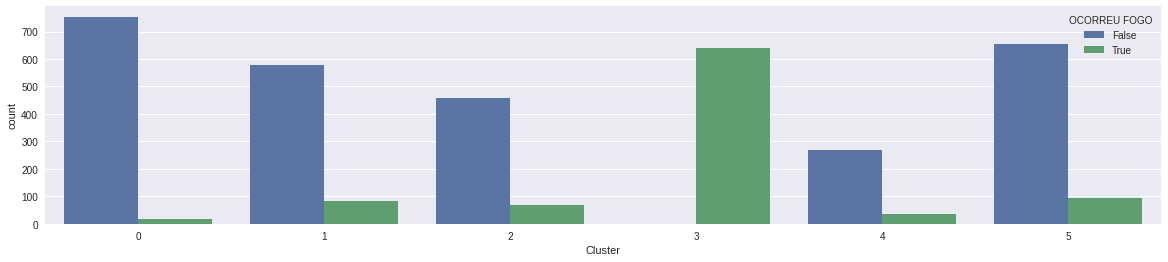

In [ ]:
cluster_analysis = cluster_profile(final_df).T
cluster_analysis

Vizualizando como cada variável se distribui em cada cluster:

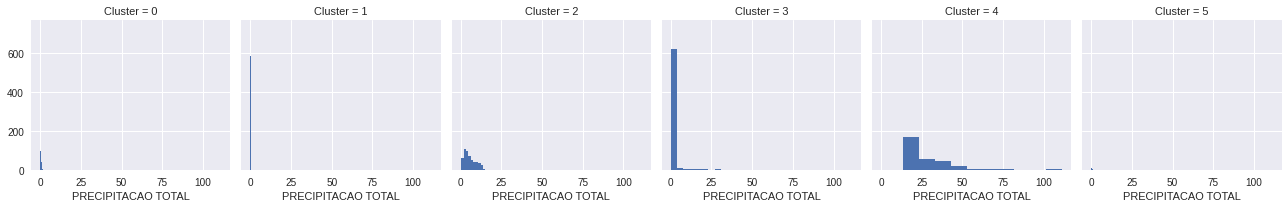

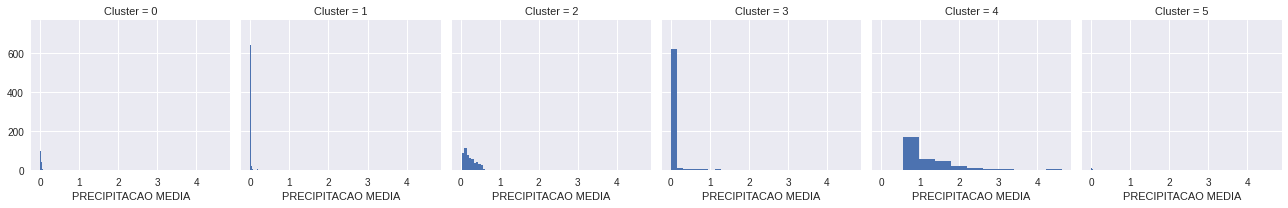

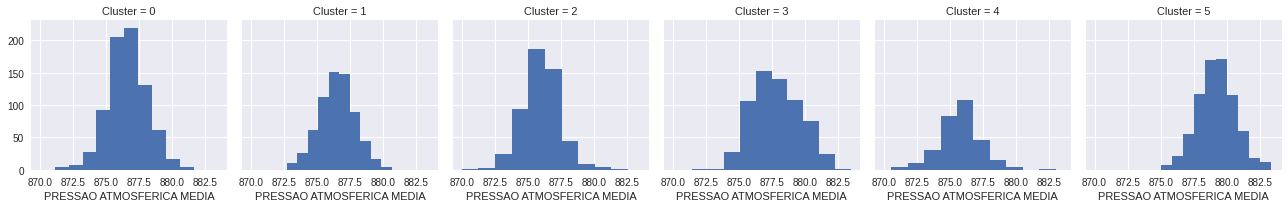

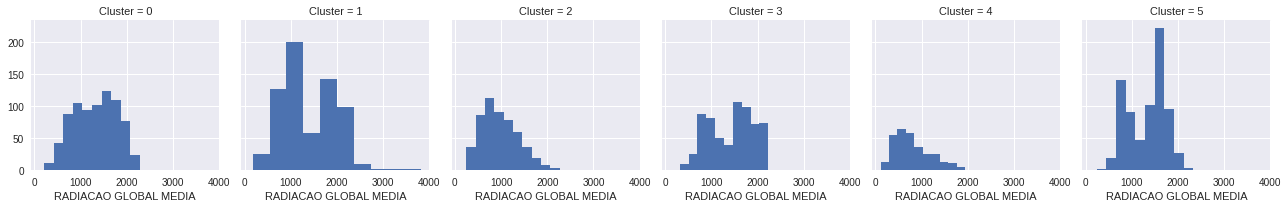

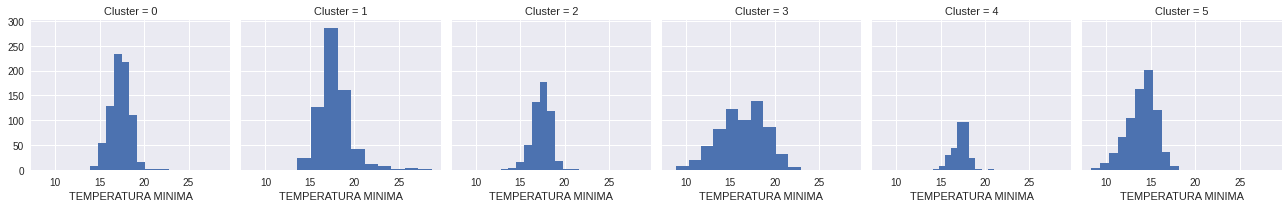

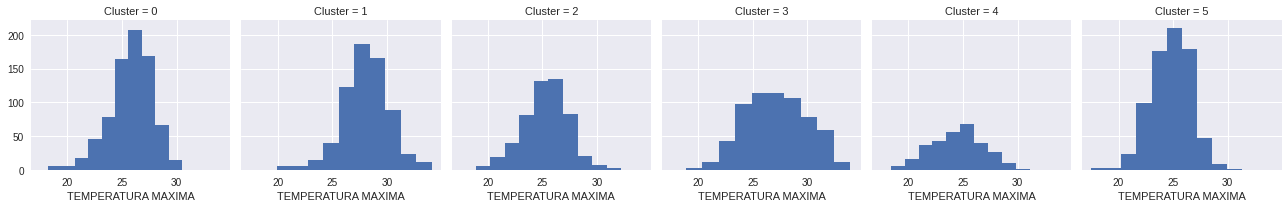

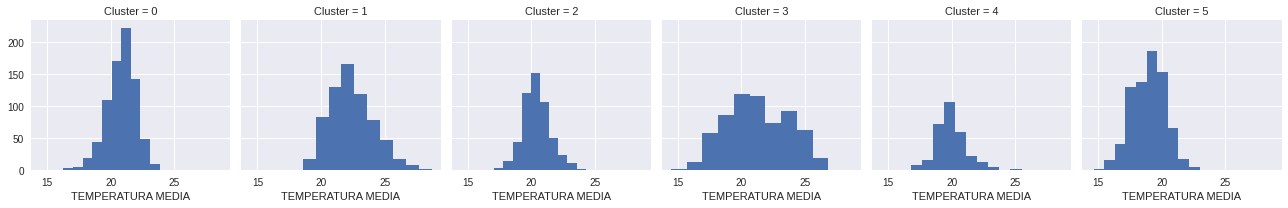

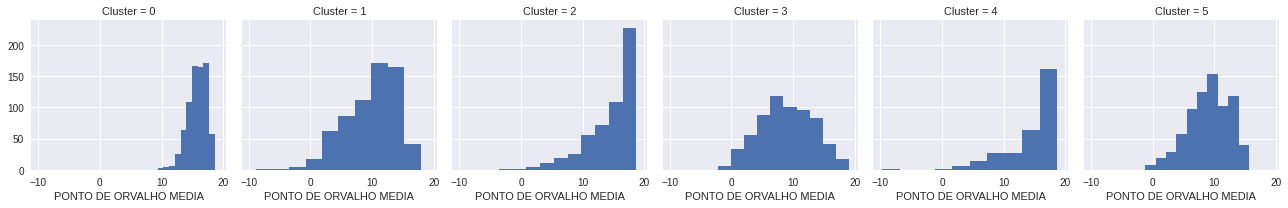

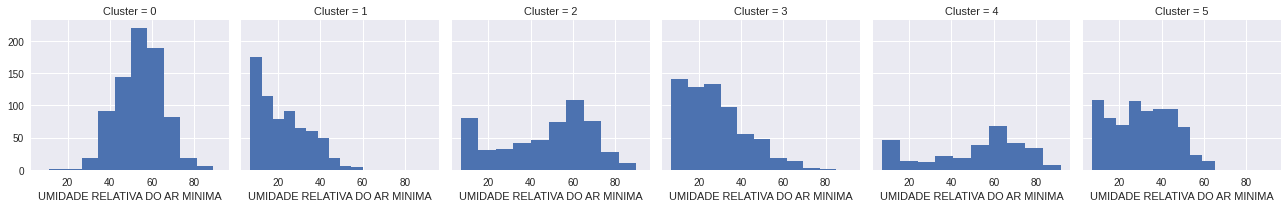

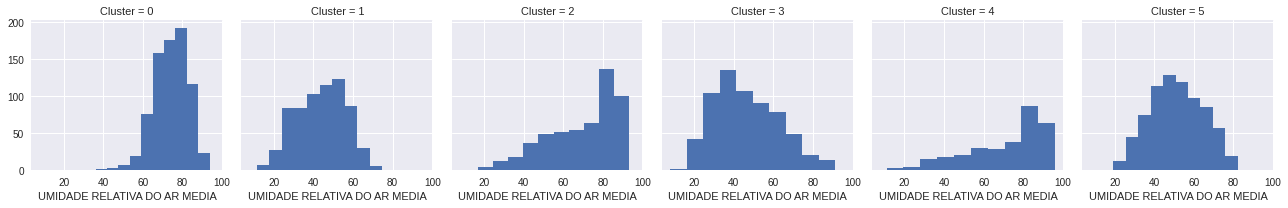

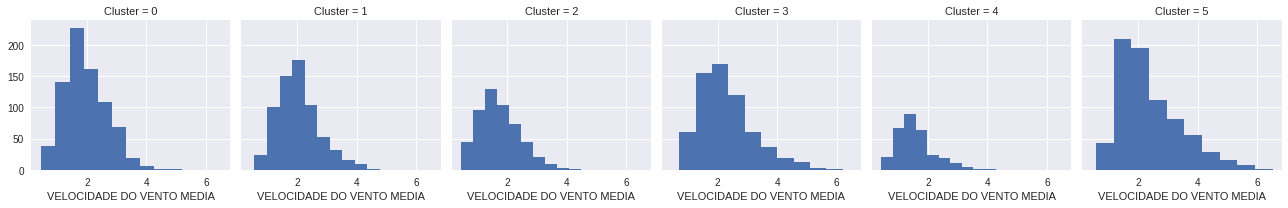

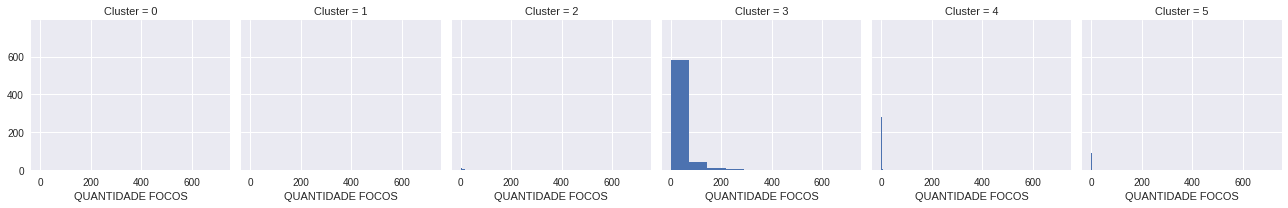

In [ ]:
for c in features_cluster:
    grid = sns.FacetGrid(final_df, col='Cluster')
    grid.map(plt.hist, c)

#  Regressão Logística

No x representar todas as colunas (variáveis explicativas) execto a última que é a variável resposta. No y deixar apenas a última coluna que é a variável resposta.

In [ ]:
queimadas = merjado.copy()
queimadas = queimadas.drop(columns=["DATA","TEMPERATURA MINIMA","QUANTIDADE FOCOS"])
queimadas.columns = queimadas.columns.str.replace(' ','')
queimadas = queimadas.replace(to_replace=True, value=1).replace(to_replace=False, value= 0)
X = queimadas.iloc[:, :-1].values
y = queimadas.iloc[:, -1].values

Calculando o percentual de ocorrência e não ocorrência de fogo

In [ ]:
def freq(x: pd.Series, plot=False):
    contagem = x.value_counts()
    percentual = round((x.value_counts() / x.shape[0]) * 100, 3)
    res = pd.DataFrame({'values': x.unique(), 'n': contagem, 'perc': percentual})
    if plot:
        sns.countplot(x)
        plt.show()
    return res

representar quantos pontos representam a o corrência de fogo e quantos representam a não ocorrência de fogo

In [ ]:
(queimadas["OCORREUFOGO"].value_counts() / queimadas.shape[0]) * 100

0    74.2951
1    25.7049
Name: OCORREUFOGO, dtype: float64

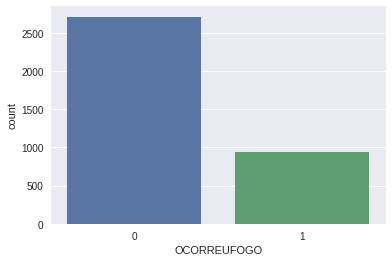

,values,n,perc
0,0,2714,74.295
1,1,939,25.705


In [ ]:
res = freq(queimadas["OCORREUFOGO"], plot= True)
res

Estimamos uma regressão logística para investigar a probabilidade de ocorência de incêndio de acordo com 10 preditores: precipitação total, precipitação média, pressão atmosférica média, radiação global média, temperatura máxima, temperatura média, ponto de orvalho médio, umidade relativa do ar média, umidade relativa do ar mínima e velocidade do vento média.
Os logits estimados só podem ser interpretados em termos de aumento ou diminuição de chances de ocorrência de incêndios já que estão em escala logarítmica. Quatro coeficientes estimados foram estatisticamente significativos (p-valor abaixo de 0.05 adotando 95% de confiança). 

In [ ]:
modelo = smf.glm(formula="OCORREUFOGO ~ PRECIPITACAOTOTAL + PRECIPITACAOMEDIA + PRESSAOATMOSFERICAMEDIA + RADIACAOGLOBALMEDIA + TEMPERATURAMAXIMA + TEMPERATURAMEDIA + PONTODEORVALHOMEDIA + UMIDADERELATIVADOARMINIMA + UMIDADERELATIVADOARMEDIA + VELOCIDADEDOVENTOMEDIA", data=queimadas,
                family = sm.families.Binomial()).fit()
print(modelo.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            OCORREUFOGO   No. Observations:                 3653
Model:                            GLM   Df Residuals:                     3642
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1885.7
Date:                Fri, 23 Sep 2022   Deviance:                       3771.4
Time:                        15:25:43   Pearson chi2:                 3.68e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

Deixando os coeficientes mais interpretáveis através de uma transformação

In [ ]:
print(np.exp(modelo.params[1:]))

PRECIPITACAOTOTAL            1.016633
PRECIPITACAOMEDIA            0.719218
PRESSAOATMOSFERICAMEDIA      1.149707
RADIACAOGLOBALMEDIA          1.000061
TEMPERATURAMAXIMA            1.190289
TEMPERATURAMEDIA             0.978796
PONTODEORVALHOMEDIA          0.925587
UMIDADERELATIVADOARMINIMA    1.004989
UMIDADERELATIVADOARMEDIA     0.990930
VELOCIDADEDOVENTOMEDIA       1.243167
dtype: float64


Demonstrando os dados em percentuais relativos. Explicando as variáveis que apresentaram p-valor abaixo de 0.05:
Os valores da pressão atmosférica influenciam positivamente em 15% na ocorrência de incêndios florestais; Quanto maior a temperatura (temperatura máxima), maiores as  chances de ocorrer incêndios sendo 19%. Quanto mais perto a temperatura está do ponto de orvalho, mais perto de 100% fica a umidade relativa, com o ar mais úmido as chances de ocorrer incêndios são menores -8%. Quanto maior a velocidade do vento maior a propagação de focos de fogo, maiores as chances de incêndios florestais 24%

In [ ]:
(np.exp(modelo.params[1:]) - 1) * 100

PRECIPITACAOTOTAL             1.663265
PRECIPITACAOMEDIA           -28.078188
PRESSAOATMOSFERICAMEDIA      14.970714
RADIACAOGLOBALMEDIA           0.006078
TEMPERATURAMAXIMA            19.028944
TEMPERATURAMEDIA             -2.120355
PONTODEORVALHOMEDIA          -7.441255
UMIDADERELATIVADOARMINIMA     0.498940
UMIDADERELATIVADOARMEDIA     -0.907009
VELOCIDADEDOVENTOMEDIA       24.316725
dtype: float64

refazendo o modelo com sckit-learn para facilitar a obtenção as métricas

In [ ]:
model = LogisticRegression(penalty='none', solver='newton-cg')
baseline_df = queimadas[['OCORREUFOGO', 'PRECIPITACAOTOTAL', 'PRECIPITACAOMEDIA', 'PRESSAOATMOSFERICAMEDIA', 'RADIACAOGLOBALMEDIA', 'TEMPERATURAMAXIMA', 'TEMPERATURAMEDIA', 'PONTODEORVALHOMEDIA', 'UMIDADERELATIVADOARMINIMA', 'UMIDADERELATIVADOARMEDIA', 'VELOCIDADEDOVENTOMEDIA']].dropna()
y = baseline_df.OCORREUFOGO
X = pd.get_dummies(baseline_df[['PRECIPITACAOTOTAL', 'PRECIPITACAOMEDIA', 'PRESSAOATMOSFERICAMEDIA', 'RADIACAOGLOBALMEDIA', 'TEMPERATURAMAXIMA', 'TEMPERATURAMEDIA', 'PONTODEORVALHOMEDIA', 'UMIDADERELATIVADOARMINIMA', 'UMIDADERELATIVADOARMEDIA', 'VELOCIDADEDOVENTOMEDIA']], drop_first=True)
print(X)

      PRECIPITACAOTOTAL  PRECIPITACAOMEDIA  PRESSAOATMOSFERICAMEDIA  \
0                   5.8           0.241667               874.591667   
1                  18.2           0.758333               872.995833   
2                  49.6           2.066667               874.816667   
3                  47.4           1.975000               876.541667   
4                   6.0           0.250000               875.770833   
...                 ...                ...                      ...   
3648               35.4           1.475000               874.258333   
3649               14.6           0.608333               876.045833   
3650                0.2           0.008333               876.650000   
3651                4.8           0.200000               874.437500   
3652               21.2           1.177778               873.650000   

      RADIACAOGLOBALMEDIA  TEMPERATURAMAXIMA  TEMPERATURAMEDIA  \
0             1172.614286               23.8         20.212500   
1              

In [ ]:
model.fit(X, y)

LogisticRegression(penalty='none', solver='newton-cg')

In [ ]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(multi_class='warn', penalty='none', solver='newton-cg')

In [ ]:
print(model.coef_)

[[ 1.60421723e-02 -3.22290655e-01  1.36121718e-01  6.22729398e-05
   1.74648473e-01 -2.36947562e-02 -7.72588757e-02  5.02345682e-03
  -9.24231718e-03  2.19358579e-01]]


In [ ]:
# Predizendo as probabilidades
queima_prob = model.predict_proba(X)

In [ ]:
queima_prob = queima_prob[:, 1] # manter somente para a classe positiva

matriz de confusão

In [ ]:
confusion_matrix(y, model.predict(X)) # usando a função do sklearn

array([[2576,  138],
       [ 782,  157]])

acurária para ver o percentual total de acertos do modelo

In [ ]:
acuracia = accuracy_score(y, model.predict(X))
print('O modelo obteve %0.4f de acurácia.' % acuracia)

O modelo obteve 0.7482 de acurácia.


O classification report do SciKit-Learn nos dá três métricas de avaliação: 
Precision é a capacidade do modelo de não prever uma instância negativa como positiva (não cometer erro do tipo 1). Para todas as instância classificadas como positivas, qual é o percentual de acerto.
Recall é a capacidade do modelo de encontrar todas as instâncias positivas. Para todas as instâncias que são de fato positivas, qual é o percentual de acerto.
A métrica F1 conjuga as duas anteriores como uma média harmônica entre ambas. 

In [ ]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      2714
           1       0.53      0.17      0.25       939

    accuracy                           0.75      3653
   macro avg       0.65      0.56      0.55      3653
weighted avg       0.71      0.75      0.70      3653



Curva ROC e AUC
A curva ROC (Receiver Operating Characteristic Curve) leva em conta a TPR (True Positive Rate Sensitity) e a FPR (False Positive Rate ou Specificity).
o AUC (Area Under the Curve) é um valor que sintetiza a informação da curva ROC. Ela varia de 0.5 a 1. Em suma, essa métrica nos diz o quanto o modelo é capaz de distinguir as duas classes. Podemos considerar uma área debaixo da curva de mais de 0.7 como aceitável. Mais de 0.8 parece bom. Mais de .9 está excelente.

In [ ]:
print('AUC: %0.2f' % roc_auc_score(y, queima_prob))

AUC: 0.71


In [ ]:
def plot_roc_curve(y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

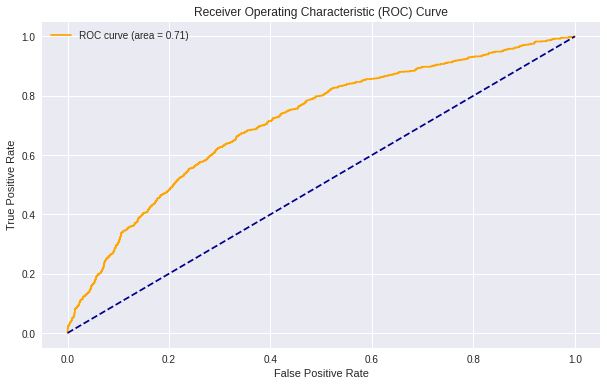

In [ ]:
plot_roc_curve(y, queima_prob)